In [1]:
import seaborn as sns
import matplotlib as mpl
%run loading_tissue
%run score_cc_finding

In [2]:
save_dir='Figures'
present_dir= '..\Presentations\Compare'
mpl.style.use('seaborn')
sns.set_style('whitegrid')

rc_pars = {'legend.facecolor': 'white', 'legend.framealpha': 0.85, "lines.linewidth": 3,
                            'legend.edgecolor':'Black', 'legend.frameon': True,
                            'legend.fancybox': True, 'legend.shadow': False,
                             'figure.figsize': [10, 7],'figure.dpi': 300}
sns.set_context('talk',  rc=rc_pars )

In [5]:
tissues_facs = ['Aorta', 'BAT', 'Bladder', 'Brain_Myeloid', 'Brain_Non-Myeloid','Diaphragm', 'GAT', 'Heart', 'Kidney',
'Large_Intestine','Limb_Muscle','Liver', 'Lung','Mammary_Gland', 'Marrow','MAT','Pancreas','SCAT','Skin', 'Spleen','Thymus','Tongue','Trachea']
tissues_droplet = ['Bladder', 'Fat', 'Heart_and_Aorta', 'Kidney',
'Large_Intestine','Limb_Muscle','Liver', 'Lung','Mammary_Gland', 'Marrow' ,'Pancreas','Skin', 'Spleen','Thymus','Tongue','Trachea']

cc_summ = {}
anim_counts = {}
cc_an = {}
all_cc = {}
tissues_by_method = {'facs': tissues_facs, 'droplet': tissues_droplet}
samp_th = 20 # minimal number of samples 
anim_th = 3 # minimal number of animals

def jitter(values, j=0, s=0.4):
    return values + np.random.normal(j, s, values.shape)

for meth in tissues_by_method.keys():
    cc_summ[meth] = combine_tissues_results(tissues=tissues_by_method[meth],method=meth, suff=', thr={:0.2f}'.format(0.15))
    cc_summ[meth]['age_m'] = cc_summ[meth].age.str.rstrip('m').astype(int)
    
    piv_animals= cc_summ[meth].pivot_table(index=['tissue', 'cell_ontology_class'], columns=['age_m','mouse.id'], 
                                                 values='cell', aggfunc='count')
    cc_animals= cc_summ[meth].pivot_table(index=['tissue', 'cell_ontology_class'], columns=['age_m','mouse.id'],
                                                values='fdr_flag_mean_score', aggfunc='sum')
    
    num_of_animals = piv_animals.shape[1]- np.array([1,3,5,9,12,15])
    anim_counts[meth]= piv_animals.quantile(num_of_animals/piv_animals.shape[1], interpolation='lower', axis=1).T
    anim_counts[meth].columns =piv_animals.shape[1]- num_of_animals

    inds = anim_counts[meth].index[anim_counts[meth][anim_th] > samp_th]
    only_above_melt = (cc_animals/piv_animals)[piv_animals.loc[inds]>samp_th].reset_index(level=(0,1)).melt(id_vars=['tissue','cell_ontology_class']).dropna()

    cc_an[meth] = (cc_animals)[piv_animals.loc[inds] > samp_th].reset_index(level=(0,1)).melt(id_vars=['tissue','cell_ontology_class'],value_name='cc_pos').dropna()
    tot_an = piv_animals[piv_animals.loc[inds] > samp_th].reset_index(level=(0,1)).melt(id_vars=['tissue','cell_ontology_class'],value_name='total_cells').dropna()
    cc_an[meth]['total_cells'] = tot_an.total_cells
    cc_an[meth]['cc_frac'] = cc_an[meth].cc_pos/cc_an[meth].total_cells
    cc_an[meth]['cc_std'] = (cc_an[meth].cc_frac*(1-cc_an[meth].cc_frac)/cc_an[meth].total_cells)**0.5
    cc_an[meth]['age_x'] = jitter(cc_an[meth]['age_m'])

    all_cc[meth] = cc_summ[meth].pivot_table(index=['tissue', 'cell_ontology_class'], values='fdr_flag_mean_score', aggfunc=['sum','count'])
    all_cc[meth].columns=['cc_pos','total_cells']
    all_cc[meth]['cc_frac'] = all_cc[meth].cc_pos/all_cc[meth].total_cells
    all_cc[meth]['cc_std'] = (all_cc[meth].cc_frac*(1-all_cc[meth].cc_frac)/all_cc[meth].total_cells)**0.5

In [6]:
meth = 'facs'
cc_summ[meth].loc[cc_summ[meth].tissue == 'Large_Intestine'].cell_ontology_class.unique()

array(['intestinal crypt stem cell', 'enteroendocrine cell',
       'enterocyte of epithelium of large intestine',
       'large intestine goblet cell',
       'epithelial cell of large intestine', 'secretory cell',
       'Brush cell of epithelium proper of large intestine'], dtype=object)

In [7]:
    ctype = 'pancreatic B cell'
    # ctype = 'Monocyte'
    agg_by_age = cc_an[meth].loc[cc_an[meth].cell_ontology_class==ctype].groupby(['age_m','tissue']).sum().reset_index()
    agg_by_age.cc_frac = agg_by_age.cc_pos/agg_by_age.total_cells
    agg_by_age.cc_std = (agg_by_age.cc_frac*(1-agg_by_age.cc_frac)/agg_by_age.total_cells)**0.5

    agg_by_age

age_m    tissue  cc_pos  total_cells   cc_frac    cc_std
0      3  Pancreas     3.0        522.0  0.005747  0.003309
1     18  Pancreas     0.0        367.0  0.000000  0.000000
2     24  Pancreas     0.0        453.0  0.000000  0.000000

In [8]:
def plot_cc_vs_age_by_tissue(ctypes, by='tissue', meth='droplet', hue_order=None, ax=None, save_dir=None, **kw):
    flag_1_type = False
    if type(ctypes) is not list:
        flag_1_type = True
        ctypes = [ctypes]
    if ax is None:
        plt.figure(figsize=(12,7))
        ax = plt.gca()
  
    agg_by_age = cc_an[meth].loc[cc_an[meth].cell_ontology_class.isin(ctypes)].groupby(['age_m',by]).sum().reset_index()
    agg_by_age.cc_frac = agg_by_age.cc_pos/agg_by_age.total_cells
    agg_by_age.cc_std = (agg_by_age.cc_frac*(1-agg_by_age.cc_frac)/agg_by_age.total_cells)**0.5
    agg_by_age['age_x'] = jitter(agg_by_age['age_m'], s=0.25)
    if hue_order is None:
        hue_order = agg_by_age[by].unique()

    ax = sns.scatterplot(data=agg_by_age, x='age_x', y='cc_frac', hue=by, hue_order=hue_order, s=100, ax=ax, **kw)
    eb = ax.errorbar(agg_by_age.age_x, agg_by_age.cc_frac, yerr=agg_by_age.cc_std, ls='', lw=1, color='k', marker=None, 
            capsize=3, capthick=1.5,  zorder=5)
    sns.scatterplot(data=cc_an[meth].loc[cc_an[meth].cell_ontology_class.isin(ctypes)], x='age_x', y='cc_frac', hue=by,
    s=50, style='mouse.id',hue_order=hue_order, legend=False, ax=ax, alpha=0.6, **kw)
    ax.legend(loc='center left',bbox_to_anchor=(1.01,0.5))
    plt.xlim(0,32)
    plt.tight_layout()
    plt.xlabel('Age [months]')
    plt.ylabel('Fraction in CC')
    
    plt.title('{} - {}'.format(ctypes[0] if flag_1_type else ctypes, meth))
    if save_dir is not None:
        plt.savefig('{}/cc_by_age_{}_{}.png'.format(save_dir,ctypes[0] if flag_1_type else ctypes,meth))

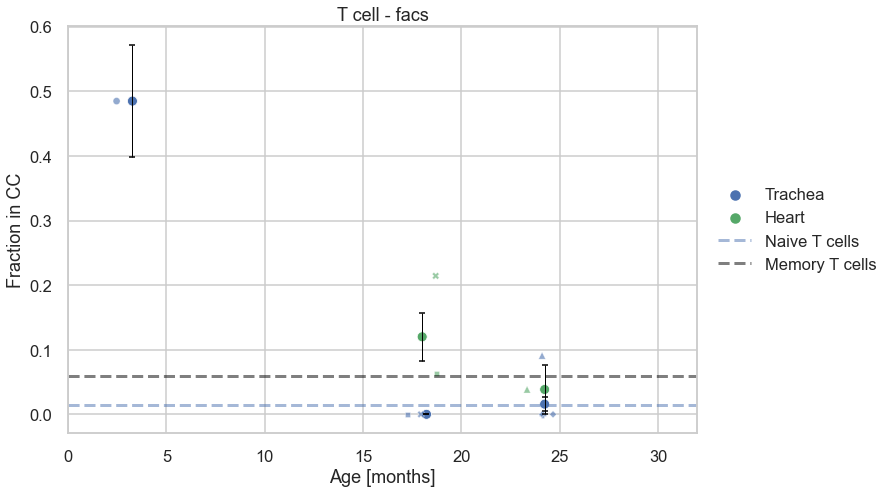

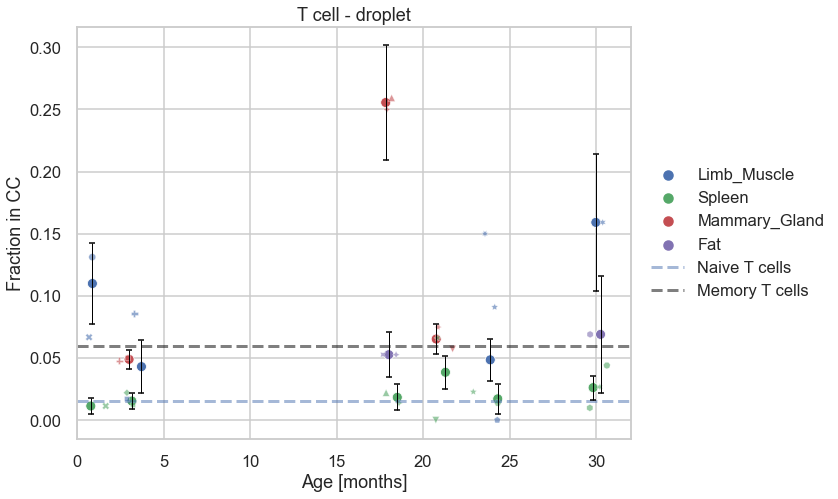

In [7]:
ctypes = 'T cell'
for meth in tissues_by_method.keys():
    plot_cc_vs_age_by_tissue(ctypes=ctypes, meth=meth)
    plt.hlines(y=0.015, xmin=0, xmax=32, ls='--', color='C0', alpha=0.5, lw=3, label='Naive T cells')
    plt.hlines(y=0.06, xmin=0, xmax=32, ls='--', color='k', alpha=0.5, lw=3, label='Memory T cells')
    plt.legend(loc='center left',bbox_to_anchor=(1.01,0.5))
    plt.savefig('{}/cc_by_age_{}_{}.png'.format(present_dir,ctypes,meth))

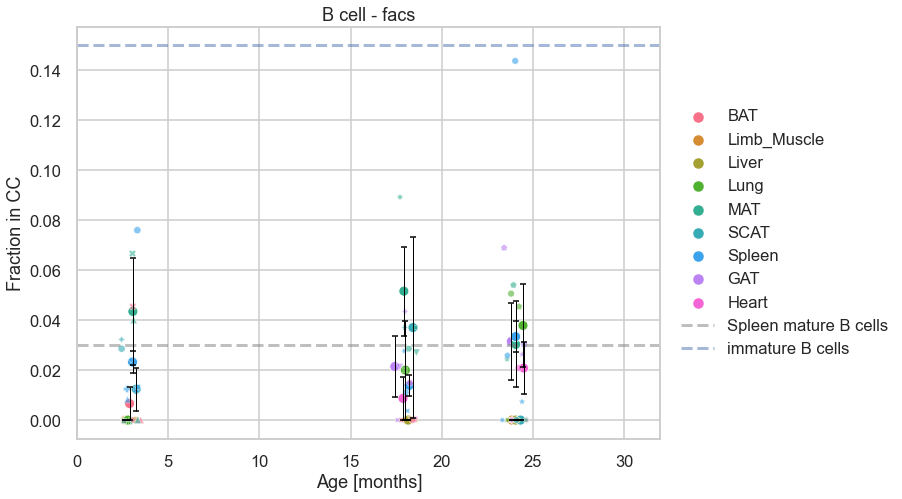

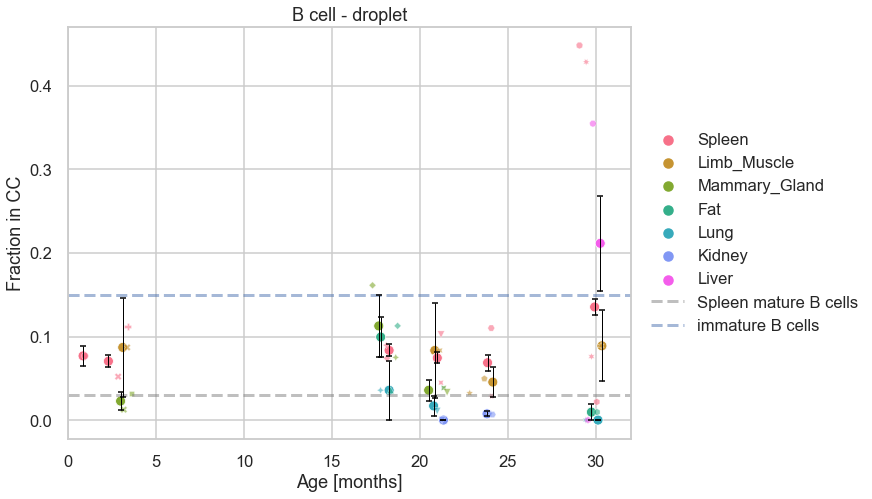

In [8]:
ctypes = 'B cell'
for meth in tissues_by_method.keys():
    plot_cc_vs_age_by_tissue(ctypes=ctypes, meth=meth)
    plt.hlines(y=0.03, xmin=0, xmax=32, ls='--', color='grey', alpha=0.5, lw=3, label='Spleen mature B cells')
    plt.hlines(y=0.15, xmin=0, xmax=32, ls='--', color='C0', alpha=0.5, lw=3, label='immature B cells')
    plt.legend(loc='center left',bbox_to_anchor=(1.01,0.5))
    plt.savefig('{}/cc_by_age_{}_{}.png'.format(present_dir,ctypes,meth))

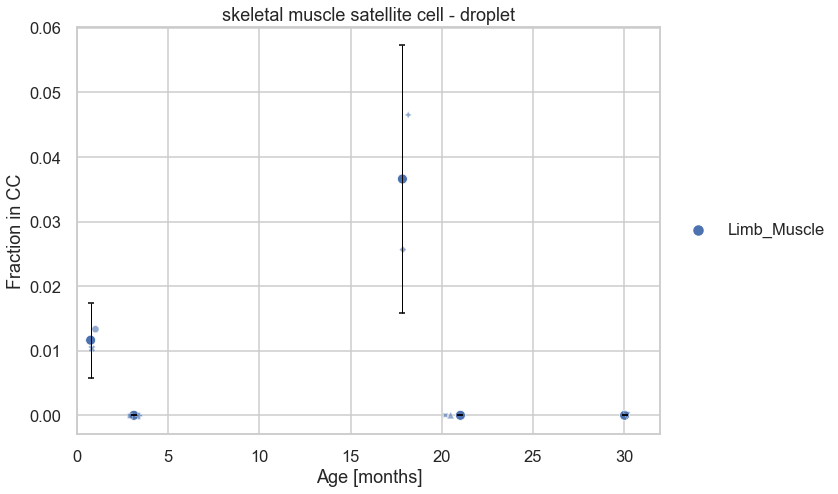

In [9]:

plot_cc_vs_age_by_tissue(ctypes='skeletal muscle satellite cell', meth='droplet')

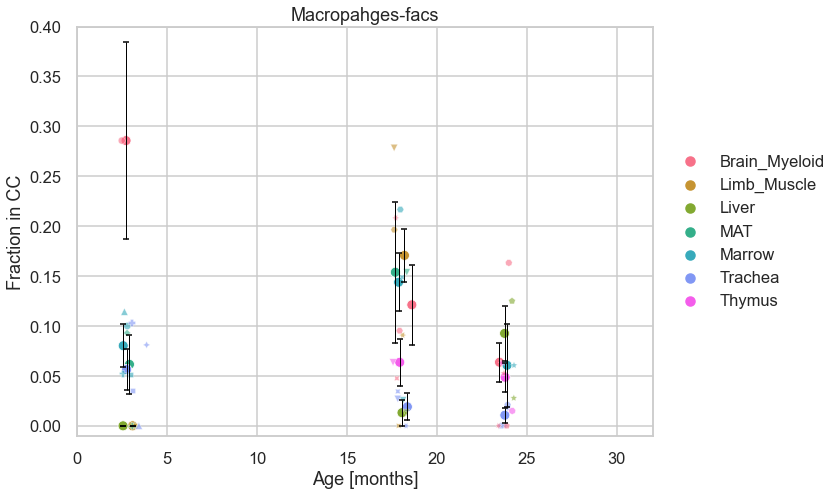

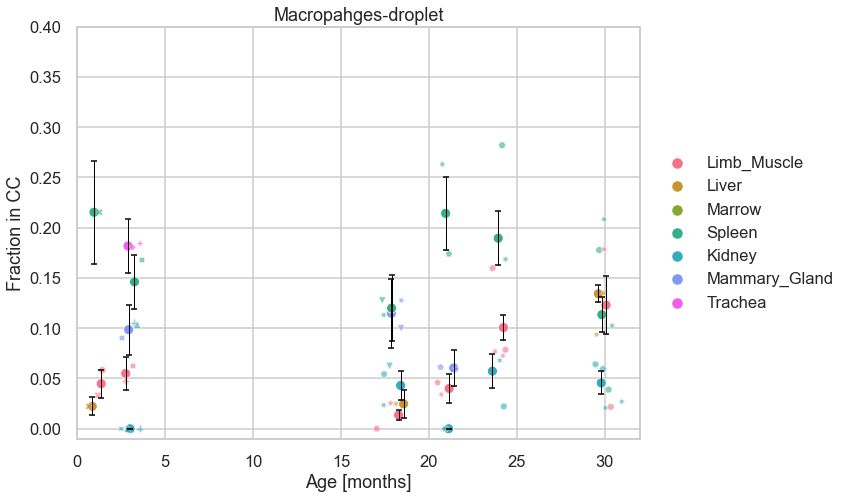

In [7]:
ctypes=['macrophage','Kupffer cell']
for meth in tissues_by_method.keys():
    plot_cc_vs_age_by_tissue(ctypes=ctypes, meth=meth)
    plt.ylim(-0.01,0.4)
    plt.title("{}-{}".format("Macropahges", meth))
    plt.savefig('{}/cc_by_age_{}_{}.png'.format(present_dir,ctypes[0],meth))


(-0.01, 0.4)

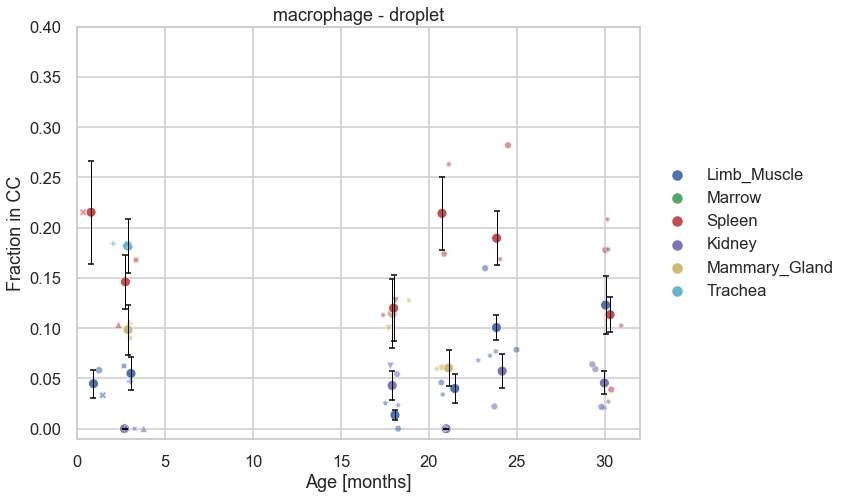

In [11]:
plot_cc_vs_age_by_tissue(ctypes='macrophage', meth='droplet')
plt.ylim(-0.01,0.4)


In [56]:
# cc_an[meth][cc_an[meth].cell_ontology_class.str.contains('fibroblast')]
meth = 'droplet'
# cc_an[meth][cc_an[meth].cell_ontology_class.str.contains('kidney')]
# kid_ctypes = cc_an[meth][cc_an[meth].cell_ontology_class.str.contains('kidney')].cell_ontology_class.unique().tolist()
kid_ctypes = cc_an[meth][cc_an[meth].tissue == 'Kidney'].cell_ontology_class.unique().tolist()
kid_ctypes = list(set(kid_ctypes) - {'B cell', 'lymphocyte', 'macrophage'})
# cc_an[meth][cc_an[meth].tissue == 'Heart_and_Aorta']
# cc_an[meth][cc_an[meth].tissue.str.contains('at')]
# fat_ctypes = 'mesenchymal stem cell of adipose'
# mono_ctypes = cc_an[meth].cell_ontology_class[cc_an[meth].cell_ontology_class.str.contains('monocyte')].unique().tolist()

In [68]:
#  cc_an[meth][cc_an[meth].tissue == 'Kidney']
# cc_an[meth][cc_an[meth].cell_ontology_class == 'podocyte']


tissue                                cell_ontology_class age_m  \
24    Kidney                                         brush cell     1   
26    Kidney                                   fenestrated cell     1   
29    Kidney              kidney collecting duct principal cell     1   
30    Kidney                          kidney cortex artery cell     1   
32    Kidney  kidney loop of Henle thick ascending limb epit...     1   
...      ...                                                ...   ...   
3545  Kidney                 epithelial cell of proximal tubule    30   
3549  Kidney              kidney collecting duct principal cell    30   
3552  Kidney  kidney loop of Henle thick ascending limb epit...    30   
3554  Kidney  kidney proximal convoluted tubule epithelial cell    30   
3558  Kidney                                           podocyte    30   

     mouse.id  cc_pos  total_cells   cc_frac    cc_std    age_x  
24     1-M-62     0.0         29.0  0.000000  0.000000  1.29823  
26     1-M-62     1.0         29.0  0.034483  0.033883  1.63594  
29     1-M-62     0.0         30.0  0.000000  0.000000  1.19565  
30     1-M-62     0.0         21.0  0.000000  0.000000   1.1414  
32     1-M-62     1.0        143.0  0.006993  0.006969   0.9161  
...       ...     ...          ...       ...       ...      ...  
3545   30-M-5     0.0        274.0  0.000000  0.000000  30.2664  
3549   30-M-5     6.0         76.0  0.078947  0.030932  29.1131  
3552   30-M-5     0.0         33.0  0.000000  0.000000  30.4213  
3554   30-M-5     0.0        135.0  0.000000  0.000000  30.2001  
3558   30-M-5     0.0         24.0  0.000000  0.000000  30.4979  

[86 rows x 9 columns]

In [100]:
# all_cc['facs'].loc['smooth muscle cell']
# all_cc[meth][all_cc[meth].index.get_level_values(1).str.contains('smooth muscle cell')]
meth = 'droplet'
# 'facs'

all_cc[meth][all_cc[meth].index.get_level_values(1).str.contains('endoth')]

cc_pos  total_cells  \
tissue          cell_ontology_class                                         
Bladder         endothelial cell                        16.0          246   
Fat             endothelial cell                        13.0          845   
Heart_and_Aorta endothelial cell of coronary artery     31.0         1360   
Kidney          kidney capillary endothelial cell        6.0           64   
Limb_Muscle     endothelial cell                        31.0         1168   
Liver           endothelial cell of hepatic sinusoid     4.0          139   
Lung            endothelial cell of lymphatic vessel     1.0            9   
                vein endothelial cell                    1.0           88   
Mammary_Gland   endothelial cell                         5.0          381   
Pancreas        endothelial cell                        24.0           68   
Trachea         endothelial cell                         4.0          112   

                                                       cc_frac    cc_std  \
tissue          cell_ontology_class                                        
Bladder         endothelial cell                      0.065041  0.015722   
Fat             endothelial cell                      0.015385  0.004234   
Heart_and_Aorta endothelial cell of coronary artery   0.022794  0.004047   
Kidney          kidney capillary endothelial cell     0.093750  0.036435   
Limb_Muscle     endothelial cell                      0.026541  0.004703   
Liver           endothelial cell of hepatic sinusoid  0.028777  0.014180   
Lung            endothelial cell of lymphatic vessel  0.111111  0.104757   
                vein endothelial cell                 0.011364  0.011299   
Mammary_Gland   endothelial cell                      0.013123  0.005830   
Pancreas        endothelial cell                      0.352941  0.057952   
Trachea         endothelial cell                      0.035714  0.017535   

                                                      lit_cc_frac  \
tissue          cell_ontology_class                                 
Bladder         endothelial cell                         0.004786   
Fat             endothelial cell                         0.007400   
Heart_and_Aorta endothelial cell of coronary artery      0.006231   
Kidney          kidney capillary endothelial cell        0.006501   
Limb_Muscle     endothelial cell                         0.001267   
Liver           endothelial cell of hepatic sinusoid     0.012533   
Lung            endothelial cell of lymphatic vessel     0.007476   
                vein endothelial cell                         NaN   
Mammary_Gland   endothelial cell                              NaN   
Pancreas        endothelial cell                              NaN   
Trachea         endothelial cell                              NaN   

                                                      lit_cc_sd_low  \
tissue          cell_ontology_class                                   
Bladder         endothelial cell                           0.000370   
Fat             endothelial cell                           0.002121   
Heart_and_Aorta endothelial cell of coronary artery        0.001797   
Kidney          kidney capillary endothelial cell          0.003373   
Limb_Muscle     endothelial cell                           0.000363   
Liver           endothelial cell of hepatic sinusoid       0.001764   
Lung            endothelial cell of lymphatic vessel       0.007892   
                vein endothelial cell                           NaN   
Mammary_Gland   endothelial cell                                NaN   
Pancreas        endothelial cell                                NaN   
Trachea         endothelial cell                                NaN   

                                                      lit_cc_sd_hi  
tissue          cell_ontology_class                                 
Bladder         endothelial cell                          0.000344  
Fat             endothelial cell  

In [99]:
all_cc[meth].loc['Lung']

cc_pos  total_cells  \
cell_ontology_class                                                    
B cell                                              6.0          276   
CD4-positive, alpha-beta T cell                     0.0           59   
CD8-positive, alpha-beta T cell                     7.0          119   
NK cell                                             0.0           52   
T cell                                              1.0           28   
adventitial cell                                    0.0          289   
bronchial smooth muscle cell                       11.0         2117   
ciliated columnar cell of tracheobronchial tree     6.0           52   
classical monocyte                                  1.0          202   
club cell of bronchiole                             1.0           22   
dendritic cell                                      0.0           62   
endothelial cell of lymphatic vessel                1.0           99   
fibroblast of lung                                  0.0          483   
intermediate monocyte                               0.0           12   
leukocyte                                          14.0           38   
lung macrophage                                     0.0            9   
lung neuroendocrine cell                            0.0            4   
lymphocyte                                          0.0           10   
mature NK T cell                                    0.0            6   
myeloid dendritic cell                             29.0          373   
neutrophil                                          0.0          123   
non-classical monocyte                              0.0          149   
pericyte cell                                       0.0           38   
plasma cell                                         0.0           25   
plasmacytoid dendritic cell                         0.0            6   
pulmonary interstitial fibroblast                   0.0           50   
regulatory T cell                                   0.0           47   
respiratory basal cell                              2.0           34   
smooth muscle cell of the pulmonary artery          0.0          111   
type I pneumocyte                                   0.0            4   
type II pneumocyte                                  0.0          167   
vein endothelial cell                               1.0          151   

                                                  cc_frac    cc_std  \
cell_ontology_class                                                   
B cell                                           0.021739  0.008778   
CD4-positive, alpha-beta T cell                  0.000000       NaN   
CD8-positive, alpha-beta T cell                  0.058824  0.021569   
NK cell                                          0.000000  0.000000   
T cell                                           0.035714  0.034643   
adventitial cell                                 0.000000  0.000000   
bronchial smooth muscle cell                     0.005196  0.001563   
ciliated columnar cell of tracheobronchial tree  0.115385  0.044305   
classical monocyte                               0.004950  0.004802   
club cell of bronchiole                          0.045455  0.044409   
dendritic cell                                   0.000000  0.000000   
endothelial cell of lymphatic vessel             0.010101  0.009798   
fibroblast of lung                               0.000000  0.000000   
intermediate monocyte                            0.000000       NaN   
leukocyte                                        0.368421  0.078252   
lung macrophage                                  0.000000  0.000000   
lung neuroendocrine cell                         0.000000  0.000000   
lymphocyte                                       0.000000       NaN   
mature NK T cell                                 0.000000  0.000000   
myeloid dendritic cell                           0.077748  0.013865   
neutrophil                            

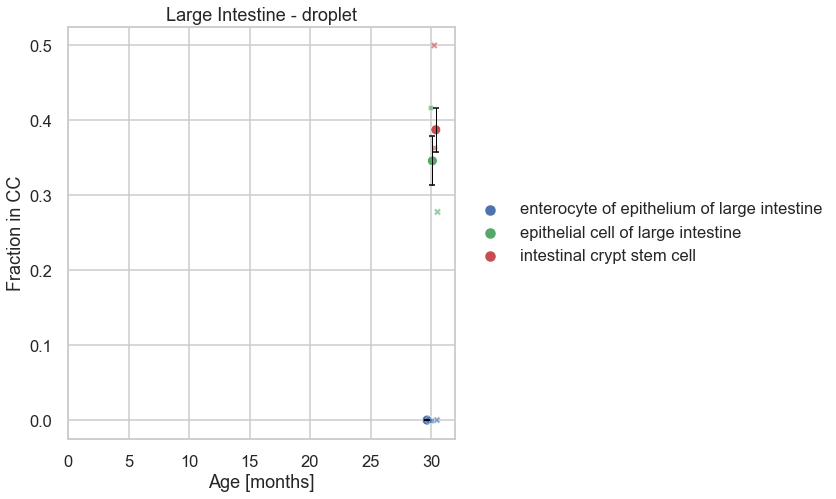

In [15]:
meth = 'droplet'
li_ctypes = cc_an[meth][cc_an[meth].tissue == 'Large_Intestine'].cell_ontology_class.unique().tolist()
# li_ctypes = list(set(kid_ctypes) - {'B cell', 'lymphocyte', 'macrophage'})
plot_cc_vs_age_by_tissue(ctypes=li_ctypes, meth=meth, by='cell_ontology_class')
plt.title('{} - {}'.format('Large Intestine',meth))
# plt.title('{} - {}'.format('Large Intestine',meth))
plt.savefig('{}/cc_by_age_{}_{}.png'.format(present_dir,'Large Intestine',meth))

# cc_an[meth][cc_an[meth].cell_ontology_class.isin(li_ctypes)]

Text(0.5, 1.0, 'kidney - facs')

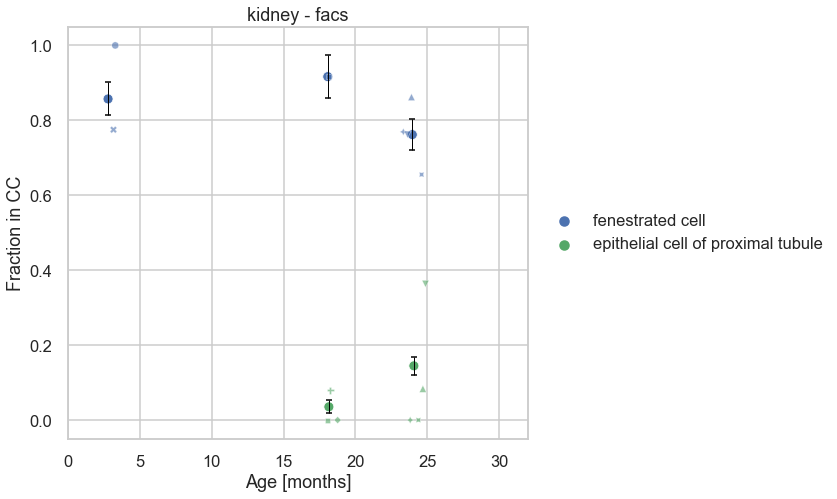

In [58]:
meth = 'facs'
plot_cc_vs_age_by_tissue(ctypes=kid_ctypes, meth=meth, by='cell_ontology_class')
plt.title('{} - {}'.format('kidney',meth))

Text(0.5, 1.0, 'Liver - droplet')

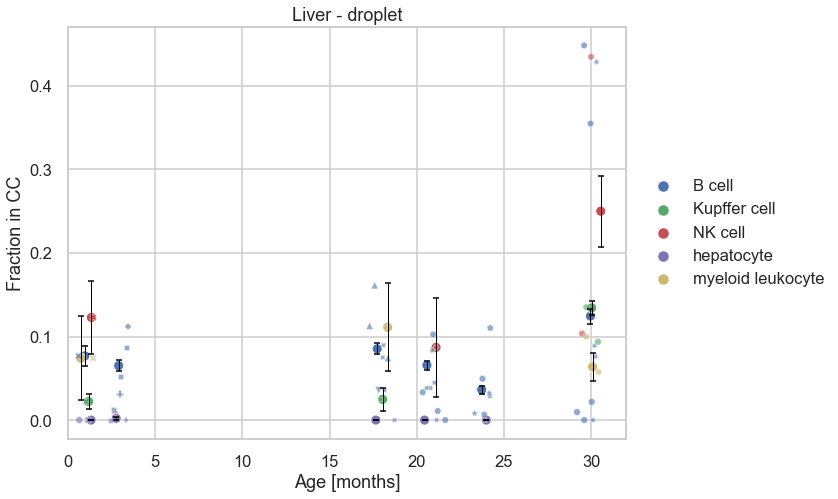

In [102]:
meth = 'droplet'
liv_ctypes = cc_an[meth][cc_an[meth].tissue == 'Liver'].cell_ontology_class.unique().tolist()
plot_cc_vs_age_by_tissue(ctypes=liv_ctypes, meth=meth, by='cell_ontology_class')
plt.title('{} - {}'.format('Liver',meth))

In [93]:
end_ctypes

['endothelial cell', 'endocardial cell', 'endothelial cell of coronary artery']

Text(0.5, 1.0, 'endothel - facs')

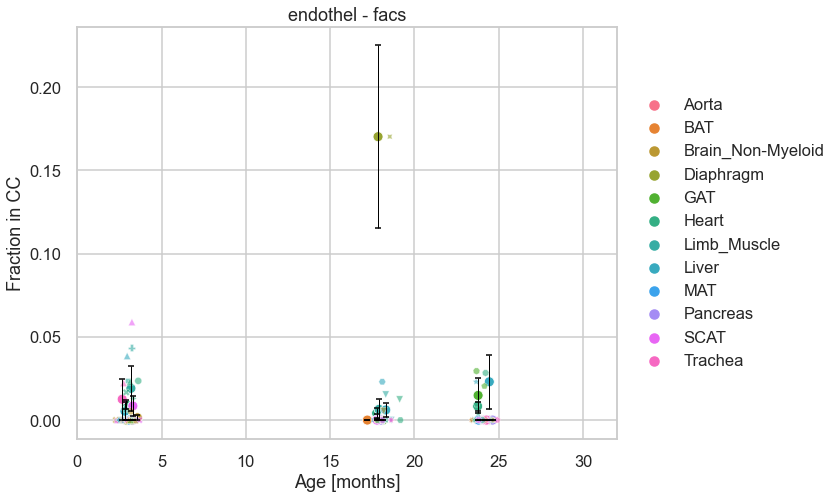

In [94]:
meth = 'droplet'
end_ctypes = cc_an[meth][cc_an[meth].cell_ontology_class.str.contains('endo')].cell_ontology_class.unique().tolist()
# kid_ctypes = list(set(kid_ctypes) - {'B cell', 'lymphocyte', 'macrophage'})
plot_cc_vs_age_by_tissue(ctypes=end_ctypes, meth=meth)
plt.title('{} - {}'.format('endothel',meth))

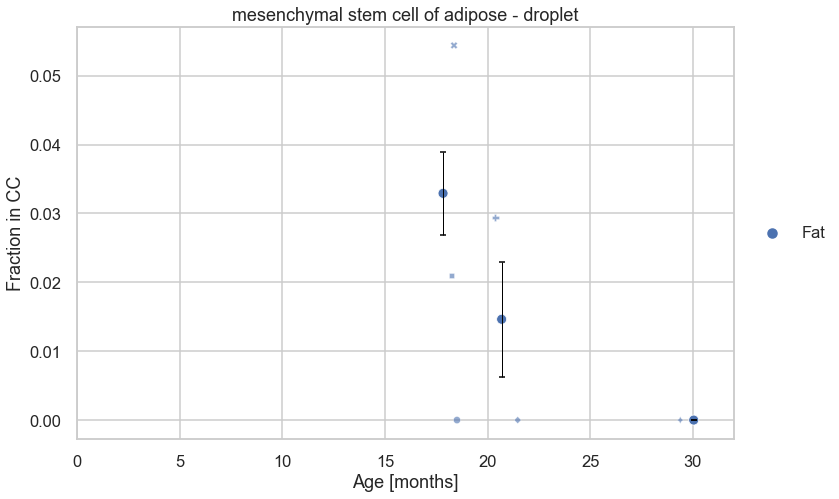

In [33]:
plot_cc_vs_age_by_tissue(ctypes=fat_ctypes, meth='droplet')

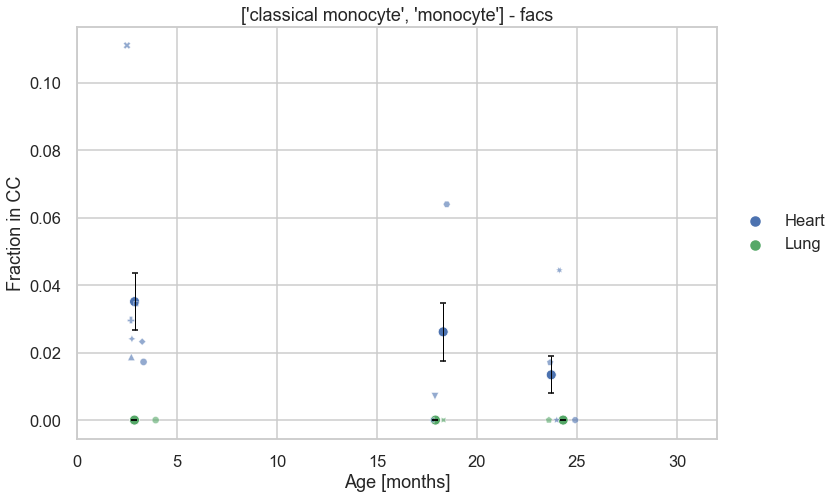

In [28]:
# plot_cc_vs_age_by_tissue(ctypes=mono_ctypes, meth='facs')
plot_cc_vs_age_by_tissue(ctypes=['classical monocyte', 'monocyte'], meth='facs')

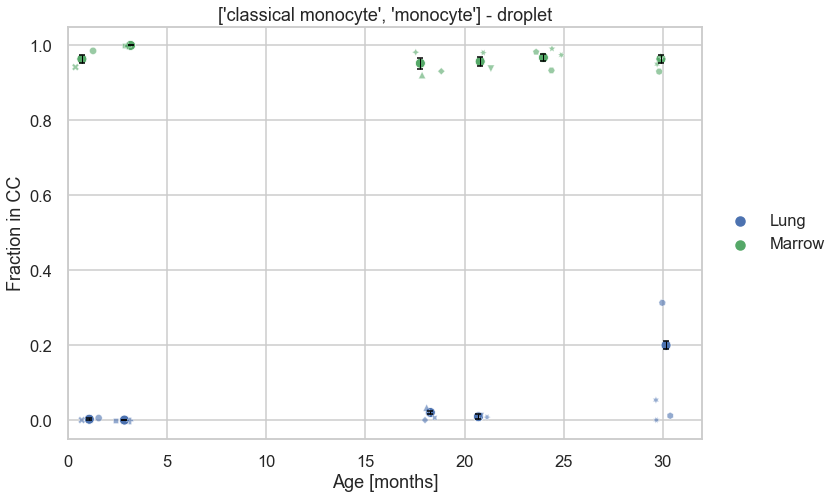

In [26]:
# plot_cc_vs_age_by_tissue(ctypes=mono_ctypes, meth='facs')
# plot_cc_vs_age_by_tissue(ctypes=mono_ctypes, meth='droplet')
# plot_cc_vs_age_by_tissue(ctypes=mono_ctypes[:3], meth='droplet')
plot_cc_vs_age_by_tissue(ctypes=['classical monocyte', 'monocyte'], meth='droplet')
# plt.ylim(-0.01,0.4)


Text(0.5, 1.0, 'fibroblast - facs')

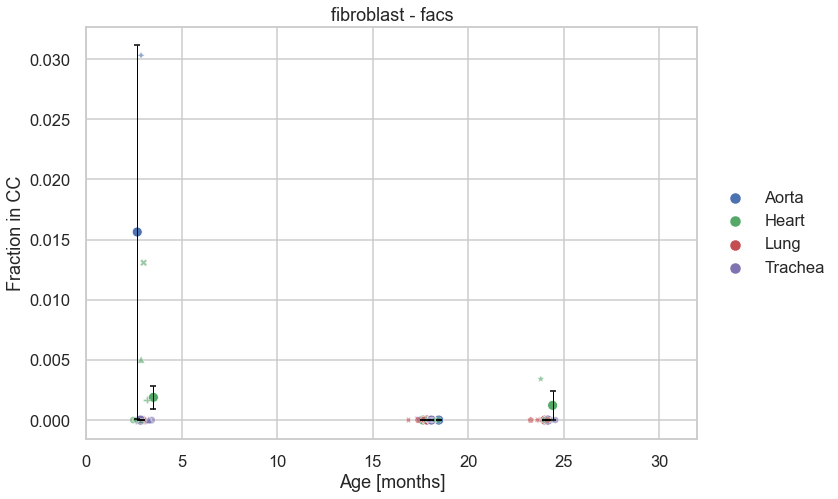

In [41]:
meth='facs'
fib_names = list(cc_an[meth].cell_ontology_class[cc_an[meth].cell_ontology_class.str.contains('fibroblast')].unique())
plot_cc_vs_age_by_tissue(ctypes=fib_names, meth=meth)
# plt.ylim(-0.01,0.4)
plt.title('fibroblast - {}'.format(meth))

In [19]:
lit = pd.read_excel('../Our dataset/cell_types_cycling_dataset.xlsx')
lit = lit[~lit.source.isnull()]
lit = lit[lit.irrelevant != 1]

lit['geom S fraction'] = lit['geom S fraction'].astype(float)
lit = lit.pivot_table(index=['tissue','cell type'],values=['geom S fraction','proliferation (1/d)', 'CC fraction',
                      'geom S frac SD', 'proliferation std (1/d)', 'CC fraction SD'], aggfunc='mean')
lit['cc_compare'] = lit['CC fraction']
lit.loc[~lit['geom S fraction'].isnull(), 'cc_compare'] = lit.loc[~lit['geom S fraction'].isnull(), 'geom S fraction']*2.5 
lit.loc[~lit['proliferation (1/d)'].isnull(), 'cc_compare'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation (1/d)'] 
lit['cc_sd_low'] = lit['CC fraction SD']
lit['cc_sd_hi'] = lit['CC fraction SD']
lit.loc[~lit['geom S fraction'].isnull(), 'cc_sd_low'] = lit.loc[~lit['geom S fraction'].isnull(), 'cc_compare']*(1 - 1/lit.loc[~lit['geom S fraction'].isnull(), 'geom S frac SD'])
lit.loc[~lit['geom S fraction'].isnull(), 'cc_sd_hi'] = lit.loc[~lit['geom S fraction'].isnull(), 'cc_compare']*(lit.loc[~lit['geom S fraction'].isnull(), 'geom S frac SD']-1)
lit.loc[~lit['proliferation (1/d)'].isnull(), 'cc_sd_low'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation std (1/d)'] 
lit.loc[~lit['proliferation (1/d)'].isnull(), 'cc_sd_hi'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation std (1/d)'] 

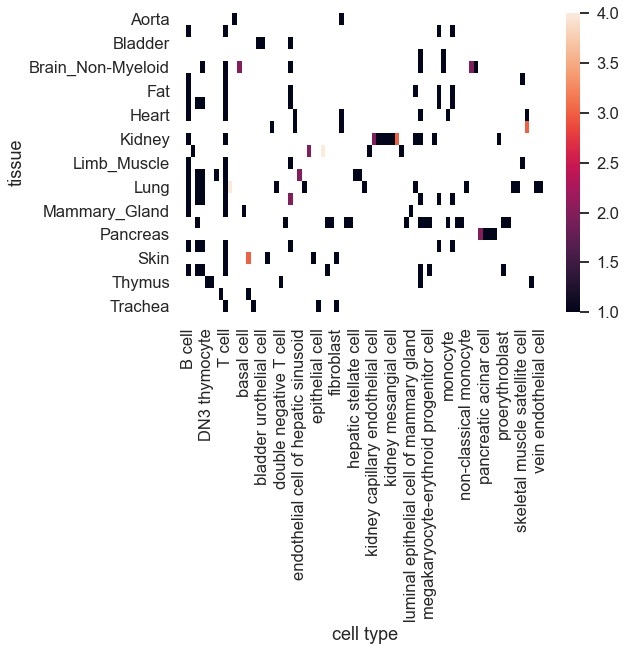

In [20]:
lit = pd.read_excel('../Our dataset/cell_types_cycling_dataset.xlsx')
lit = lit[~lit.source.isnull()]
lit = lit[lit.irrelevant != 1]

lit['geom S fraction'] = lit['geom S fraction'].astype(float)

lit['eq_cc_frac'] = lit['CC fraction']
lit.loc[~lit['geom S fraction'].isnull(), 'eq_cc_frac'] = lit.loc[~lit['geom S fraction'].isnull(), 'geom S fraction']*2.5 
lit.loc[~lit['proliferation (1/d)'].isnull(), 'eq_cc_frac'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation (1/d)'] 

lit['eq_cc_sd_hi'] = lit['CC fraction SD']
lit['eq_cc_sd_low'] = lit['CC fraction SD']
lit.loc[~lit['geom S fraction'].isnull(), 'eq_cc_sd_low'] = lit.loc[~lit['geom S fraction'].isnull(), 'eq_cc_frac']*(1 - 1/lit.loc[~lit['geom S fraction'].isnull(), 'geom S frac SD'])
lit.loc[~lit['geom S fraction'].isnull(), 'eq_cc_sd_hi'] = lit.loc[~lit['geom S fraction'].isnull(), 'eq_cc_frac']*(lit.loc[~lit['geom S fraction'].isnull(), 'geom S frac SD']-1)
lit.loc[~lit['proliferation (1/d)'].isnull(), 'eq_cc_sd_low'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation std (1/d)'] 
lit.loc[~lit['proliferation (1/d)'].isnull(), 'eq_cc_sd_hi'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation std (1/d)'] 

d = lit.pivot_table(index='tissue',columns='cell type',values='source',aggfunc='count')
sns.heatmap(d)

lit = lit.pivot_table(index=['tissue','cell type'],values=['eq_cc_frac','eq_cc_sd_low','eq_cc_sd_hi'], aggfunc='mean')
lit.columns =  ['cc_compare', 'cc_sd_low', 'cc_sd_hi']
# lit['cc_compare'] = lit['CC fraction']
# lit.loc[~lit['geom S fraction'].isnull(), 'cc_compare'] = lit.loc[~lit['geom S fraction'].isnull(), 'geom S fraction']*2.5 
# lit.loc[~lit['proliferation (1/d)'].isnull(), 'cc_compare'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation (1/d)'] 
# lit['cc_sd_low'] = lit['CC fraction SD']
# lit['cc_sd_hi'] = lit['CC fraction SD']
# lit.loc[~lit['geom S fraction'].isnull(), 'cc_sd_low'] = lit.loc[~lit['geom S fraction'].isnull(), 'cc_compare']*(1 - 1/lit.loc[~lit['geom S fraction'].isnull(), 'geom S frac SD'])
# lit.loc[~lit['geom S fraction'].isnull(), 'cc_sd_hi'] = lit.loc[~lit['geom S fraction'].isnull(), 'cc_compare']*(lit.loc[~lit['geom S fraction'].isnull(), 'geom S frac SD']-1)
# lit.loc[~lit['proliferation (1/d)'].isnull(), 'cc_sd_low'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation std (1/d)'] 
# lit.loc[~lit['proliferation (1/d)'].isnull(), 'cc_sd_hi'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation std (1/d)'] 

In [11]:
# lit = pd.read_excel('../Datasets/Unlabeled/Our dataset/cell_types_cycling_dataset.xlsx')
# lit = lit[~lit.source.isnull()]
# lit = lit[lit.irrelevant != 1]

# lit['geom S fraction'] = lit['geom S fraction'].astype(float)

# lit['eq_cc_frac'] = lit['CC fraction']
# lit.loc[~lit['geom S fraction'].isnull(), 'eq_cc_frac'] = lit.loc[~lit['geom S fraction'].isnull(), 'geom S fraction']*2.5 
# lit.loc[~lit['proliferation (1/d)'].isnull(), 'eq_cc_frac'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation (1/d)'] 

# lit['eq_cc_sd_hi'] = lit['CC fraction SD']
# lit['eq_cc_sd_low'] = lit['CC fraction SD']
# lit.loc[~lit['geom S fraction'].isnull(), 'eq_cc_sd_low'] = lit.loc[~lit['geom S fraction'].isnull(), 'eq_cc_frac']*(1 - 1/lit.loc[~lit['geom S fraction'].isnull(), 'geom S frac SD'])
# lit.loc[~lit['geom S fraction'].isnull(), 'eq_cc_sd_hi'] = lit.loc[~lit['geom S fraction'].isnull(), 'eq_cc_frac']*(lit.loc[~lit['geom S fraction'].isnull(), 'geom S frac SD']-1)
# lit.loc[~lit['proliferation (1/d)'].isnull(), 'eq_cc_sd_low'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation std (1/d)'] 
# lit.loc[~lit['proliferation (1/d)'].isnull(), 'eq_cc_sd_hi'] = lit.loc[~lit['proliferation (1/d)'].isnull(), 'proliferation std (1/d)'] 

# lit.info_type.value_counts()

In [14]:
def jitter_log(values, j=1, s=0.5):
    return values * np.random.normal(j, s, values.shape)


tot_cell_thr = 20
min_dy_ratio = 0.03
all_cc_comp = {}
for meth in tissues_by_method.keys():
    all_cc[meth]['lit_cc_frac'] = lit['cc_compare']
    all_cc[meth]['lit_cc_sd_low'] = lit['cc_sd_low']
    all_cc[meth]['lit_cc_sd_hi'] = lit['cc_sd_hi']
    all_cc_comp[meth] = all_cc[meth][(all_cc[meth].cc_frac>0) & (~all_cc[meth].lit_cc_frac.isnull())].copy()
    all_cc_comp[meth]['lit_x'] = jitter_log(all_cc_comp[meth].lit_cc_frac, s=0.05)
    all_cc_comp[meth] = all_cc_comp[meth][all_cc_comp[meth].total_cells>=tot_cell_thr]

    y = all_cc[meth].loc[~all_cc[meth].lit_cc_frac.isnull(), 'cc_frac']
    dy = all_cc[meth].loc[~all_cc[meth].lit_cc_frac.isnull(), 'cc_std']
    all_cc[meth].loc[~all_cc[meth].lit_cc_frac.isnull(), 'cc_std'] = y*(1-np.maximum((y-dy)/y, min_dy_ratio))

    all_cc_comp[meth]['miss'] = all_cc[meth].cc_frac/all_cc[meth].lit_cc_frac

Text(0.5, 1.0, 'droplet - All cells')

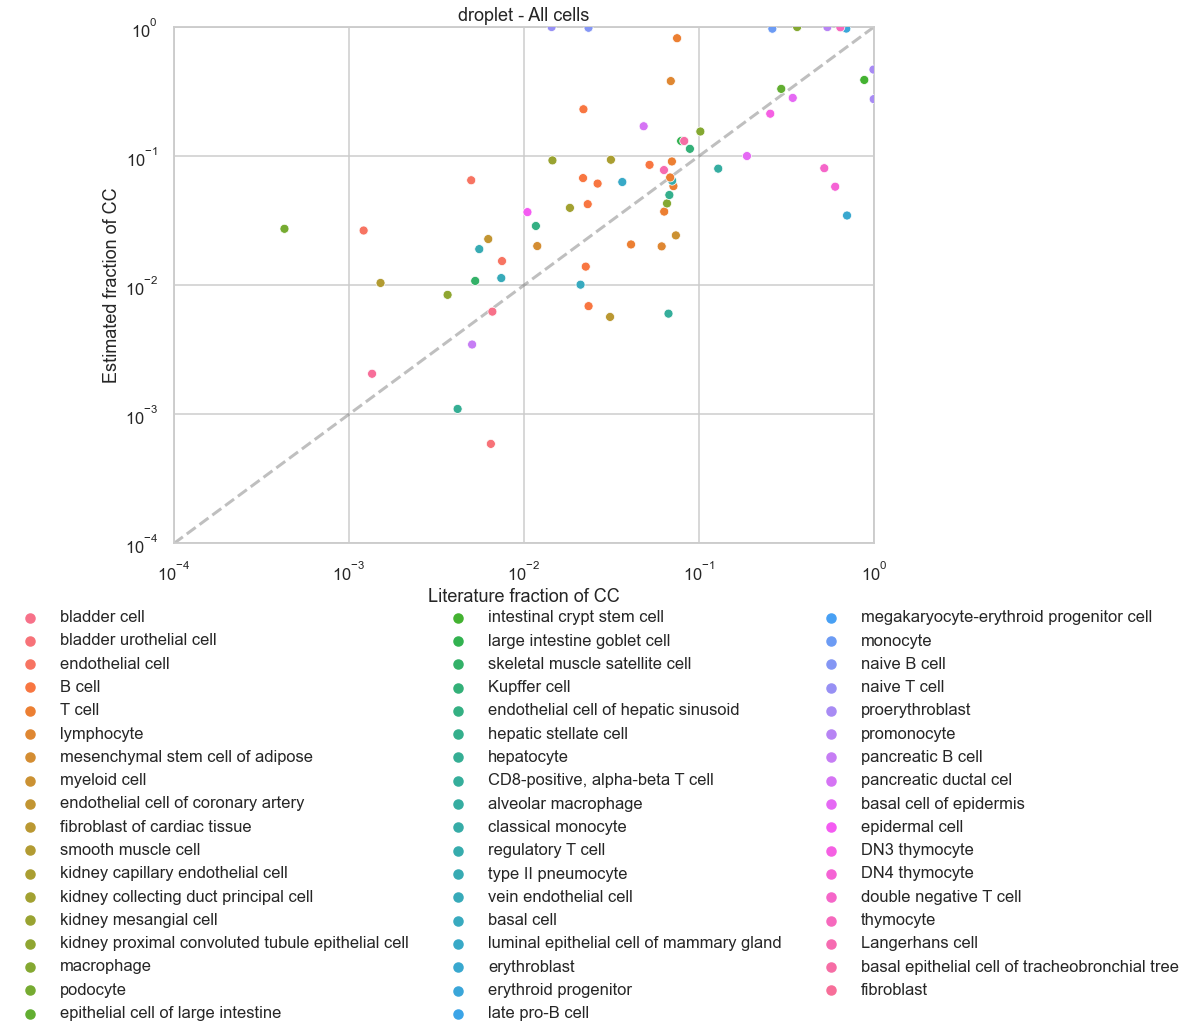

In [21]:
meth = 'droplet'
plt.figure(figsize=(15,15))

ax=plt.gca()
# eb_all = ax.errorbar(all_cc_comp[meth].lit_x, all_cc_comp[meth].cc_frac, yerr=all_cc_comp[meth].cc_std, xerr=all_cc_comp[meth][['lit_cc_sd_low','lit_cc_sd_hi']].values.T,
#              ls='', lw=2, color='k', marker='8',  capsize=5, capthick=2.5,  zorder=2, label='Over all cells')
sns.scatterplot(data=all_cc_comp[meth], x='lit_x', y='cc_frac', hue='cell_ontology_class', legend=True,ax=ax, zorder=3)
plt.plot([0.0001,1],[0.0001,1], 'grey', ls='--', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.0001,1])
plt.ylim([0.0001,1])
plt.ylabel('Estimated fraction of CC')
plt.xlabel('Literature fraction of CC')
ax.legend(loc="upper left", bbox_to_anchor=(-0.25, -0.1), ncol=3,title='')
plt.tight_layout()
plt.title('{} - All cells'.format(meth))
# plt.savefig('{}/lit_comp_all_cells_{}_new_data.png'.format(present_dir,meth))
# plt.savefig('{}/lit_comp_all_cells_{}_new_data_no_eb.png'.format(present_dir,meth))

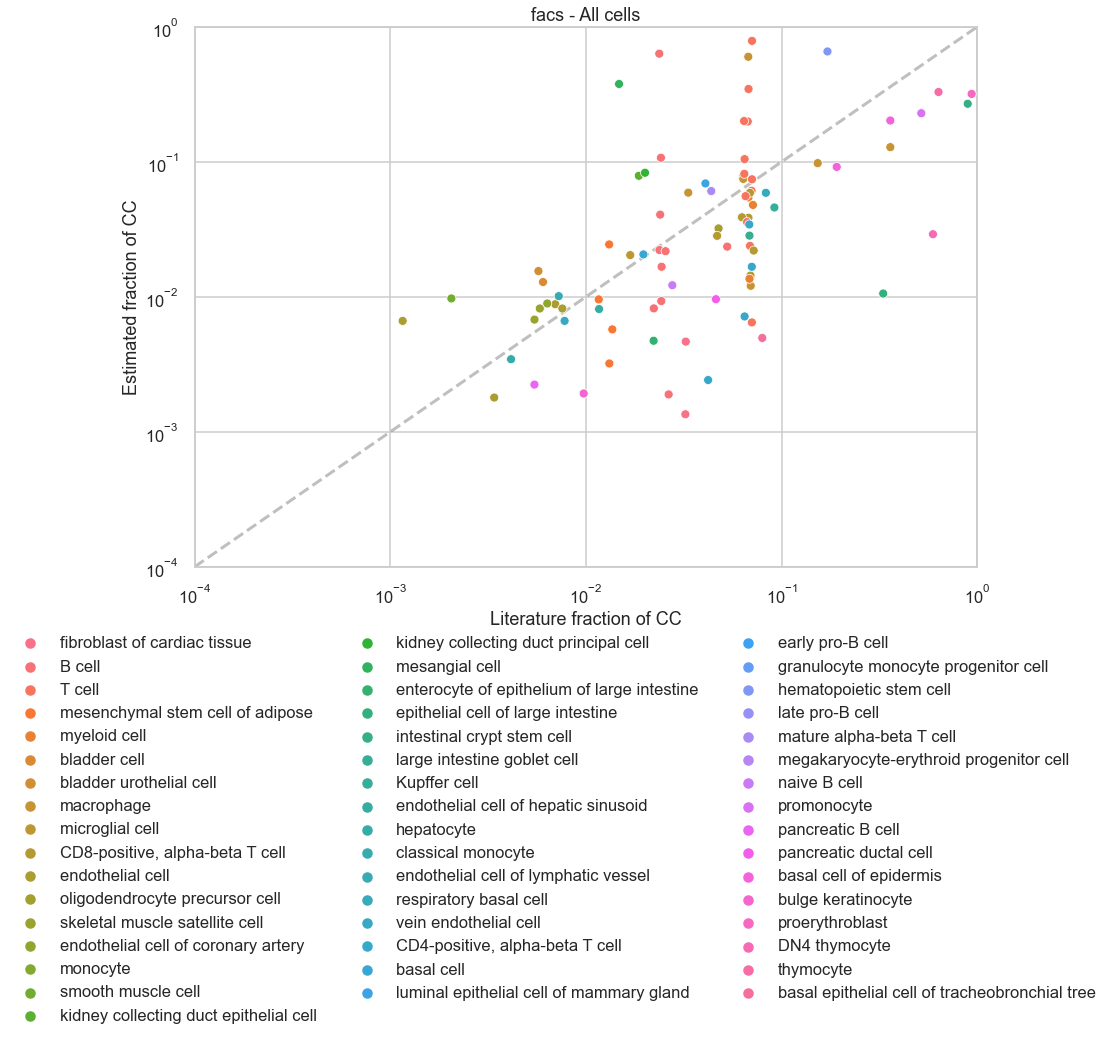

In [25]:
meth = 'facs'
plt.figure(figsize=(15,15))

ax=plt.gca()
# eb_all = ax.errorbar(all_cc_comp[meth].lit_x, all_cc_comp[meth].cc_frac, yerr=all_cc_comp[meth].cc_std, xerr=all_cc_comp[meth][['lit_cc_sd_low','lit_cc_sd_hi']].values.T,
#              ls='', lw=2, color='k', marker='8',  capsize=5, capthick=2.5,  zorder=2, label='Over all cells')
sns.scatterplot(data=all_cc_comp[meth], x='lit_x', y='cc_frac', hue='cell_ontology_class', legend=True,ax=ax, zorder=3)
plt.plot([0.0001,1],[0.0001,1], 'grey', ls='--', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Estimated fraction of CC')
plt.xlabel('Literature fraction of CC')
plt.xlim([0.0001,1])
plt.ylim([0.0001,1])
sns.move_legend(ax, "upper left", bbox_to_anchor=(-0.25, -0.1), ncol=3,title='')
plt.tight_layout()
plt.title('{} - All cells'.format(meth))
plt.savefig('{}/lit_comp_all_cells_{}_new_data_no_eb.png'.format(present_dir,meth))


cc_pos_facs  \
tissue          cell_ontology_class                                           
Bladder         bladder cell                                           13.0   
                bladder urothelial cell                                22.0   
Kidney          B cell                                                 53.0   
                T cell                                                 62.0   
                kidney collecting duct principal cell                  13.0   
                macrophage                                             91.0   
Large_Intestine epithelial cell of large intestine                     18.0   
                intestinal crypt stem cell                            424.0   
                large intestine goblet cell                            45.0   
Limb_Muscle     B cell                                                 20.0   
                T cell                                                 27.0   
                endothelial cell                                        3.0   
                skeletal muscle satellite cell                         15.0   
Liver           Kupffer cell                                           12.0   
                endothelial cell of hepatic sinusoid                    5.0   
                hepatocyte                                              4.0   
Lung            B cell                                                  6.0   
                CD8-positive, alpha-beta T cell                         7.0   
                T cell                                                  1.0   
                classical monocyte                                      1.0   
                vein endothelial cell                                   1.0   
Mammary_Gland   basal cell                                             44.0   
                luminal epithelial cell of mammary gland               53.0   
Marrow          late pro-B cell                                       382.0   
                macrophage                                             56.0   
                megakaryocyte-erythroid progenitor cell                34.0   
                naive B cell                                           36.0   
                promonocyte                                           232.0   
Pancreas        pancreatic B cell                                       3.0   
Skin            basal cell of epidermis                               153.0   
Spleen          B cell                                                 67.0   
                proerythroblast                                        34.0   
Thymus          DN4 thymocyte                                          51.0   
                thymocyte                                             530.0   
Tongue          basal cell of epidermis                               513.0   
Trachea         basal epithelial cell of tracheobronchial tree          2.0   

                                                                total_cells_facs  \
tissue          cell_ontology_class                                                
Bladder         bladder cell                                                1012   
                bladder urothelial cell                                     1420   
Kidney          B cell                                                        84   
                T cell                                                        79   
                kidney collecting duct principal cell                        157   
                macrophage                                                   152   
Large_Intestine epithelial cell of large intestine                          1704   
                intestinal crypt stem cell                                  1579   
                large intestine goblet cell                                 1587   
Limb_Muscle     B cell                                                       187   
                T cell                               

In [58]:


# merg_comp[~merg_all.is_comp].index.get_level_values(0).unique()


tissue           cell_ontology_class                           
Bladder          bladder cell                                      49.649057
                 bladder urothelial cell                           26.062614
Kidney           B cell                                            37.414562
                 T cell                                            44.029140
                 kidney collecting duct principal cell             43.132324
                 macrophage                                        45.642482
Large_Intestine  epithelial cell of large intestine                49.128516
                 intestinal crypt stem cell                        41.614183
                 large intestine goblet cell                       44.618302
Limb_Muscle      B cell                                            40.727947
                 T cell                                            47.032681
                 endothelial cell                                  19.583140
            

In [67]:
# merg_comp.miss_droplet.is
with pd.option_context('mode.use_inf_as_null', True):
   merg_comp = merg_comp.dropna()
merg_comp

cc_pos_facs  \
tissue          cell_ontology_class                                           
Bladder         bladder cell                                           13.0   
                bladder urothelial cell                                22.0   
Kidney          B cell                                                 53.0   
                T cell                                                 62.0   
                kidney collecting duct principal cell                  13.0   
                macrophage                                             91.0   
Large_Intestine epithelial cell of large intestine                     18.0   
                intestinal crypt stem cell                            424.0   
                large intestine goblet cell                            45.0   
Limb_Muscle     B cell                                                 20.0   
                T cell                                                 27.0   
                endothelial cell                                        3.0   
                skeletal muscle satellite cell                         15.0   
Liver           Kupffer cell                                           12.0   
                endothelial cell of hepatic sinusoid                    5.0   
                hepatocyte                                              4.0   
Lung            B cell                                                  6.0   
                CD8-positive, alpha-beta T cell                         7.0   
                T cell                                                  1.0   
                vein endothelial cell                                   1.0   
Mammary_Gland   basal cell                                             44.0   
                luminal epithelial cell of mammary gland               53.0   
Marrow          late pro-B cell                                       382.0   
                macrophage                                             56.0   
                megakaryocyte-erythroid progenitor cell                34.0   
                naive B cell                                           36.0   
                promonocyte                                           232.0   
Pancreas        pancreatic B cell                                       3.0   
Skin            basal cell of epidermis                               153.0   
Spleen          B cell                                                 67.0   
Thymus          DN4 thymocyte                                          51.0   
                thymocyte                                             530.0   
Tongue          basal cell of epidermis                               513.0   
Trachea         basal epithelial cell of tracheobronchial tree          2.0   

                                                                total_cells_facs  \
tissue          cell_ontology_class                                                
Bladder         bladder cell                                                1012   
                bladder urothelial cell                                     1420   
Kidney          B cell                                                        84   
                T cell                                                        79   
                kidney collecting duct principal cell                        157   
                macrophage                                                   152   
Large_Intestine epithelial cell of large intestine                          1704   
                intestinal crypt stem cell                                  1579   
                large intestine goblet cell                                 1587   
Limb_Muscle     B cell                                                       187   
                T cell                                                       136   
                endothelial cell                                             453   
                skeletal muscle satellite c

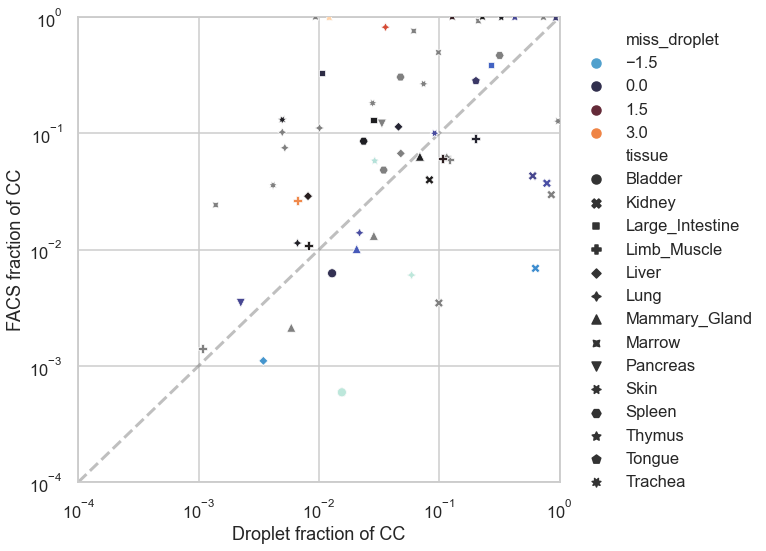

In [74]:
# pd.concat([all_cc_comp['facs'], all_cc_comp['droplet']])
# all_cc_comp['facs'].merge(all_cc_comp['droplet'],left_index=True, right_index=True, suffixes=['_facs','_droplet'])
plt.figure(figsize=(11,8))
ax=plt.gca()
merg_all =all_cc['facs'].merge(all_cc['droplet'],left_index=True, right_index=True, suffixes=['_facs','_droplet'])
merg_all['is_comp'] = ~merg_all.lit_cc_frac_facs.isnull()
sty_order= merg_all.index.get_level_values(0).unique()
merg_comp = all_cc_comp['facs'].merge(all_cc_comp['droplet'],left_index=True, right_index=True, suffixes=['_facs','_droplet'])
with pd.option_context('mode.use_inf_as_null', True):
   merg_comp = merg_comp.dropna()
sns.scatterplot(data=merg_all, x='cc_frac_facs', y='cc_frac_droplet', style=merg_all.index.get_level_values(0),
 style_order=sty_order, color='grey',legend=False,ax=ax, zorder=3)
sns.scatterplot(data=merg_comp, x='cc_frac_facs', y='cc_frac_droplet', style=merg_comp.index.get_level_values(0), style_order=sty_order, 
ax=ax, zorder=3, legend=True, hue=np.log(merg_comp.miss_droplet), palette="icefire")
plt.plot([0.0001,1],[0.0001,1], 'grey', ls='--', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('FACS fraction of CC')
plt.xlabel('Droplet fraction of CC')
plt.xlim([0.0001,1])
plt.ylim([0.0001,1])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1), ncol=1,title='')
plt.tight_layout()
plt.savefig('{}/method_comparison_by_tissue.png'.format(present_dir))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Empty DataFrame
Columns: [tissue, cell_ontology_class, age_m, mouse.id, cc_pos, total_cells, cc_frac, cc_std, age_x]
Index: []

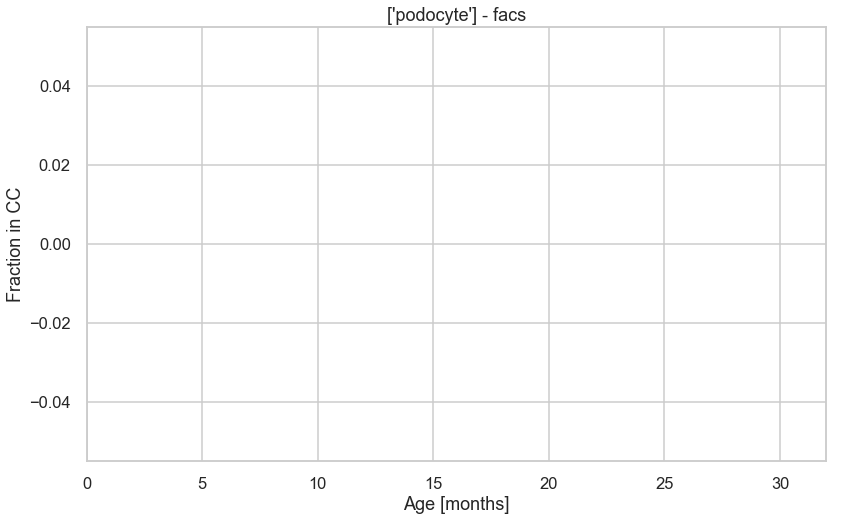

In [61]:
# plot_cc_vs_age_by_tissue(ctypes=mono_ctypes, meth='facs')
meth='facs'
# ctypes=['basal cell', 'luminal epithelial cell of mammary gland']
ctypes=['podocyte']
plot_cc_vs_age_by_tissue(ctypes=ctypes, meth=meth)
cc_an[meth].loc[cc_an[meth].cell_ontology_class.isin(ctypes)]

In [119]:

# all_cc[meth].loc['Liver']
all_cc['facs'].loc['Skin']

cc_pos  total_cells   cc_frac    cc_std  lit_cc_frac  \
cell_ontology_class                                                             
T cell                      2.0           27  0.074074  0.050401     0.067568   
basal cell of epidermis   153.0         1672  0.091507  0.007051          NaN   
bulge keratinocyte          5.0         2603  0.001921  0.000858          NaN   
epidermal cell              0.0          492  0.000000  0.000000          NaN   
fibroblast                  0.0           17  0.000000       NaN     0.004865   
keratinocyte stem cell     34.0           35  0.971429  0.028160          NaN   
macrophage                  0.0           13  0.000000  0.000000          NaN   

                         lit_cc_sd_low  lit_cc_sd_hi  
cell_ontology_class                                   
T cell                        0.011000      0.011000  
basal cell of epidermis            NaN           NaN  
bulge keratinocyte                 NaN           NaN  
epidermal cell                     NaN           NaN  
fibroblast                    0.003964      0.002184  
keratinocyte stem cell             NaN           NaN  
macrophage                         NaN           NaN

In [105]:
meth = 'droplet'
# meth = 'facs'
# all_cc_comp[meth].loc['Fat']
all_cc_comp[meth].loc['Liver']

cc_pos  total_cells   cc_frac    cc_std  \
cell_ontology_class                                                             
B cell                                  21.0           91  0.230769  0.044167   
Kupffer cell                           234.0         2054  0.113924  0.007010   
endothelial cell of hepatic sinusoid     4.0          139  0.028777  0.014180   

                                      lit_cc_frac  lit_cc_sd_low  \
cell_ontology_class                                                
B cell                                   0.024250       0.002425   
Kupffer cell                             0.088608       0.004430   
endothelial cell of hepatic sinusoid     0.012533       0.001764   

                                      lit_cc_sd_hi     lit_x      miss  
cell_ontology_class                                                     
B cell                                    0.002205  0.025599  9.516257  
Kupffer cell                              0.004430  0.092002  1.285714  
endothelial cell of hepatic sinusoid      0.001705  0.012175  2.296020

In [64]:
# end_drop = all_cc_comp[meth][all_cc_comp[meth].index.get_level_values(1).str.contains('endothelial')]
mac_drop = all_cc_comp[meth][all_cc_comp[meth].index.get_level_values(1).isin(['macrophage', 'Kupffer cell', 'myeloid cell','alveolar macrophage', 'Langerhans cell'])]



cc_pos  total_cells   cc_frac    cc_std  \
tissue cell_ontology_class                                            
Fat    myeloid cell           38.0         1562  0.024328  0.003898   
Kidney macrophage             40.0          930  0.043011  0.006653   
Liver  Kupffer cell          234.0         2054  0.113924  0.007010   
Lung   alveolar macrophage    52.0          650  0.080000  0.010641   
Marrow macrophage            970.0          970  1.000000  0.000000   
Spleen macrophage            155.0          999  0.155155  0.011455   
Tongue Langerhans cell        11.0          141  0.078014  0.022586   

                            lit_cc_frac  lit_cc_sd_low  lit_cc_sd_hi  \
tissue cell_ontology_class                                             
Fat    myeloid cell            0.067600       0.023000      0.023000   
Kidney macrophage              0.066500       0.023335      0.023335   
Liver  Kupffer cell            0.088608       0.004430      0.004430   
Lung   alveolar macrophage     0.152404       0.011854      0.012854   
Marrow macrophage              0.355000       0.026514      0.028655   
Spleen macrophage              0.101899       0.020253      0.020253   
Tongue Langerhans cell         0.060000       0.010000      0.010000   

                               lit_x      miss  
tissue cell_ontology_class                      
Fat    myeloid cell         0.071287  0.359878  
Kidney macrophage           0.066817  0.646778  
Liver  Kupffer cell         0.090801  1.285714  
Lung   alveolar macrophage  0.158217  0.524922  
Marrow macrophage           0.361354  2.816901  
Spleen macrophage           0.101184  1.522641  
Tongue Langerhans cell      0.058853  1.300236

tissue cell_ontology_class  cc_pos  total_cells   cc_frac  \
0             BAT        myeloid cell    59.0          756  0.078042   
1   Brain_Myeloid          macrophage    28.0          287  0.097561   
2             GAT        myeloid cell    39.0          718  0.054318   
3           Heart          macrophage     1.0           83  0.012048   
4          Kidney          macrophage    91.0          152  0.598684   
5           Liver        Kupffer cell    12.0          262  0.045802   
6             MAT          macrophage    17.0          228  0.074561   
7             MAT        myeloid cell     3.0          221  0.013575   
8          Marrow          macrophage    56.0          437  0.128146   
9            SCAT        myeloid cell    41.0          857  0.047841   
10         Thymus          macrophage    22.0          373  0.058981   

      cc_std  lit_cc_frac  lit_cc_sd_low  lit_cc_sd_hi     lit_x      miss  \
0   0.009756     0.067600       0.023000      0.023000  0.064047  1.154472   
1   0.017515     0.144000       0.050000      0.050000  0.146166  0.677507   
2   0.008458     0.067600       0.023000      0.023000  0.070723  0.803514   
3   0.011687     0.067500       0.013920      0.011540  0.067643  0.178492   
4   0.039758     0.066500       0.023335      0.023335  0.070622  9.002770   
5   0.012915     0.088608       0.004430      0.004430  0.091203  0.516903   
6   0.017397     0.067600       0.023000      0.023000  0.064687  1.102979   
7   0.007784     0.067600       0.023000      0.023000  0.069165  0.200809   
8   0.015989     0.355000       0.028655      0.026514  0.331754  0.360976   
9   0.007291     0.067600       0.023000      0.023000  0.061954  0.707712   
10  0.012198     0.036458       0.019444      0.012681  0.038200  1.617771   

                    tiss_ctype  
0           BAT - myeloid cell  
1   Brain_Myeloid - macrophage  
2           GAT - myeloid cell  
3           Heart - macrophage  
4          Kidney - macrophage  
5         Liver - Kupffer cell  
6             MAT - macrophage  
7           MAT - myeloid cell  
8          Marrow - macrophage  
9          SCAT - myeloid cell  
10         Thymus - macrophage

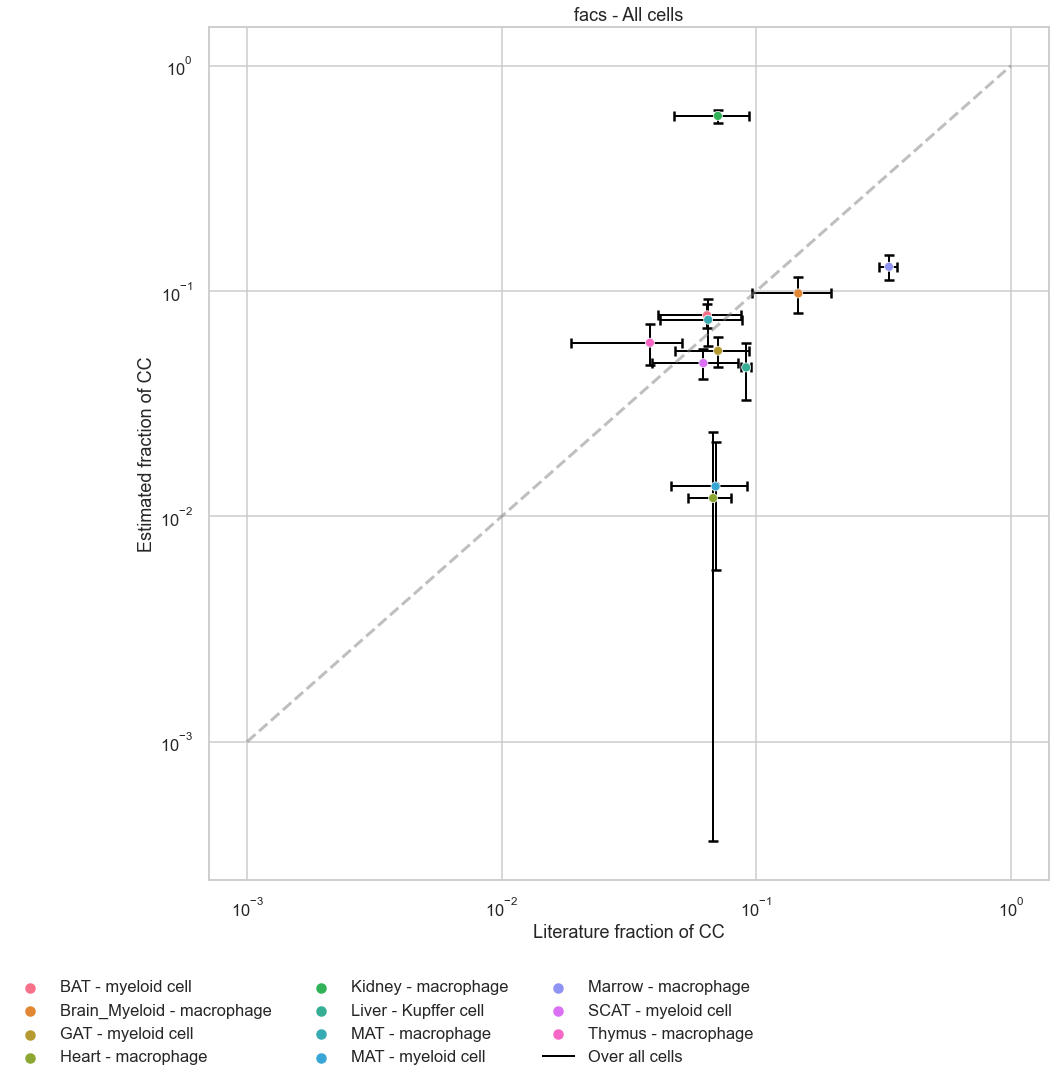

In [73]:
meth = 'facs'
mac_drop = all_cc_comp[meth][all_cc_comp[meth].index.get_level_values(1).isin(['macrophage', 'Kupffer cell', 'myeloid cell','alveolar macrophage', 'Langerhans cell'])].reset_index()

plt.figure(figsize=(15,15))

ax=plt.gca()
eb_all = ax.errorbar(mac_drop.lit_x, mac_drop.cc_frac, yerr=mac_drop.cc_std, xerr=mac_drop[['lit_cc_sd_low','lit_cc_sd_hi']].values.T,
             ls='', lw=2, color='k', marker='8',  capsize=5, capthick=2.5,  zorder=2, label='Over all cells')
# sns.scatterplot(data=mac_drop, x='lit_x', y='cc_frac', hue='cell_ontology_class', legend=True,ax=ax, zorder=3)
mac_drop['tiss_ctype'] = mac_drop.apply(lambda r: '{} - {}'.format(r.tissue, r.cell_ontology_class), axis=1)
sns.scatterplot(data=mac_drop, x='lit_x', y='cc_frac', hue='tiss_ctype', legend=True,ax=ax, zorder=3)
plt.plot([0.001,1],[0.001,1], 'grey', ls='--', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Estimated fraction of CC')
plt.xlabel('Literature fraction of CC')
sns.move_legend(ax, "upper left", bbox_to_anchor=(-0.25, -0.1), ncol=3,title='')
plt.tight_layout()
plt.title('{} - All cells'.format(meth))
# plt.savefig('{}/lit_comp_all_cells_{}_new_data.png'.format(present_dir,meth))
mac_drop

Text(0.5, 1.0, 'droplet - All cells')

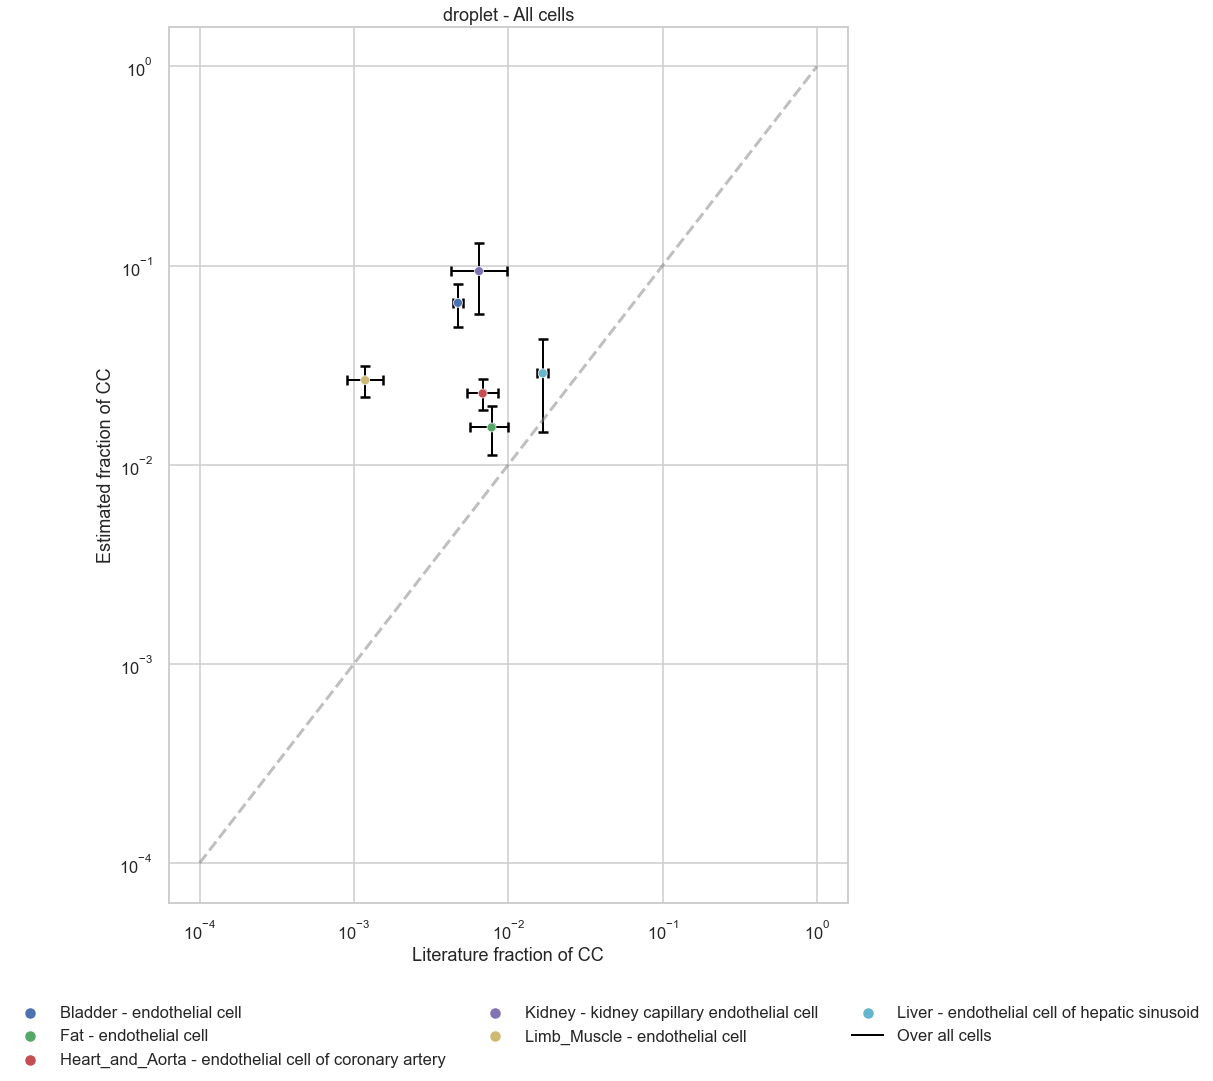

In [67]:
meth = 'droplet'
end_drop = all_cc_comp[meth][all_cc_comp[meth].index.get_level_values(1).str.contains('endothelial')].reset_index()

plt.figure(figsize=(15,15))

ax=plt.gca()
eb_all = ax.errorbar(end_drop.lit_x, end_drop.cc_frac, yerr=end_drop.cc_std, xerr=end_drop[['lit_cc_sd_low','lit_cc_sd_hi']].values.T,
             ls='', lw=2, color='k', marker='8',  capsize=5, capthick=2.5,  zorder=2, label='Over all cells')
end_drop['tiss_ctype'] = end_drop.apply(lambda r: '{} - {}'.format(r.tissue, r.cell_ontology_class), axis=1)
sns.scatterplot(data=end_drop, x='lit_x', y='cc_frac', hue='tiss_ctype', legend=True,ax=ax, zorder=3)
plt.plot([0.0001,1],[0.0001,1], 'grey', ls='--', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Estimated fraction of CC')
plt.xlabel('Literature fraction of CC')
sns.move_legend(ax, "upper left", bbox_to_anchor=(-0.25, -0.1), ncol=3,title='')
plt.tight_layout()
plt.title('{} - All cells'.format(meth))
# plt.savefig('{}/lit_comp_all_cells_{}_new_data.png'.format(present_dir,meth))


In [165]:
all_cc_comp[meth]

cc_pos  \
tissue          cell_ontology_class                                      
Bladder         bladder cell                                      15.0   
                bladder urothelial cell                            3.0   
                endothelial cell                                  16.0   
Fat             B cell                                            19.0   
                T cell                                            13.0   
                endothelial cell                                  13.0   
                lymphocyte                                         1.0   
Heart_and_Aorta endothelial cell of coronary artery               31.0   
                fibroblast of cardiac tissue                      12.0   
Kidney          B cell                                             6.0   
                T cell                                            18.0   
                kidney capillary endothelial cell                  6.0   
                lymphocyte                                       396.0   
Limb_Muscle     B cell                                            19.0   
                T cell                                            40.0   
                endothelial cell                                  31.0   
Liver           B cell                                            21.0   
                endothelial cell of hepatic sinusoid               4.0   
Lung            B cell                                             4.0   
                CD8-positive, alpha-beta T cell                    3.0   
                T cell                                            77.0   
                alveolar macrophage                               52.0   
                classical monocyte                               338.0   
                lung macrophage                                   20.0   
                regulatory T cell                                  2.0   
                type II pneumocyte                                 2.0   
Mammary_Gland   B cell                                            20.0   
                T cell                                            89.0   
Marrow          naive T cell                                    1550.0   
Spleen          B cell                                           575.0   
                T cell                                            28.0   
Thymus          thymocyte                                       1738.0   
Trachea         basal epithelial cell of tracheobronchial tree    52.0   
                fibroblast                                         1.0   
                macrophage                                        38.0   

                                                                total_cells  \
tissue          cell_ontology_class                                           
Bladder         bladder cell                                           2402   
                bladder urothelial cell                                5081   
                endothelial cell                                        246   
Fat             B cell                                                  281   
                T cell                                                  222   
                endothelial cell                                        845   
                lymphocyte                                               50   
Heart_and_Aorta endothelial cell of coronary artery                    1360   
                fibroblast of cardiac tissue                           2112   
Kidney          B cell                                                  871   
                T cell                                                  484   
                kidney capillary endothelial cell                        64   
                lymphocyte                                             1038   
Limb_Muscle     B cell                                                  310   
                T cell                                       

c:\Users\ronse\Anaconda3\lib\site-packages\numpy\core\_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\ronse\Anaconda3\lib\site-packages\numpy\core\_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Text(0.5, 1.0, 'facs - All cells')

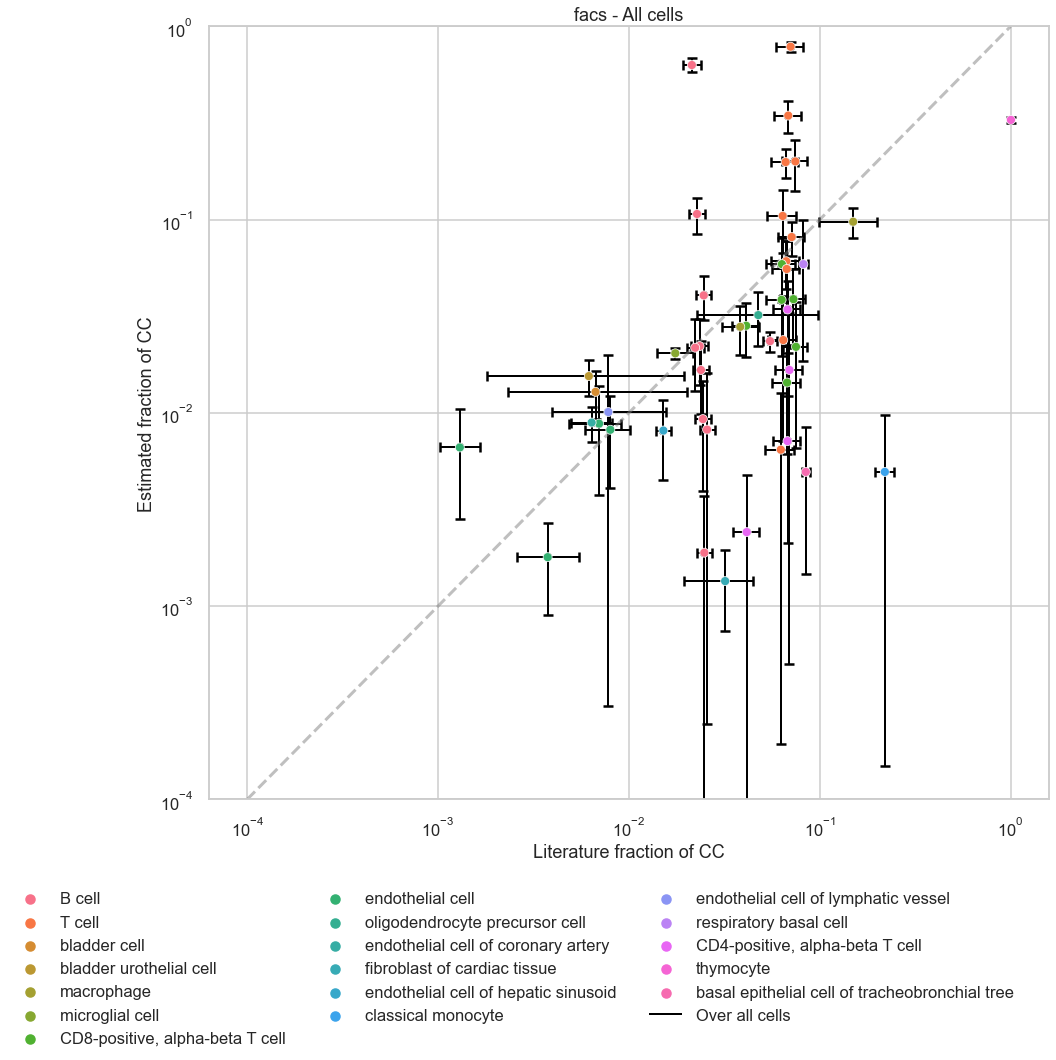

In [155]:
meth = 'facs'
plt.figure(figsize=(15,15))

ax=plt.gca()
eb_all = ax.errorbar(all_cc_comp[meth].lit_x, all_cc_comp[meth].cc_frac, yerr=all_cc_comp[meth].cc_std, xerr=all_cc_comp[meth][['lit_cc_sd_low','lit_cc_sd_hi']].values.T,
             ls='', lw=2, color='k', marker='8',  capsize=5, capthick=2.5,  zorder=2, label='Over all cells')
# hue = list(zip(all_cc_comp[meth].reset_index().tissue, all_cc_comp[meth].reset_index().cell_ontology_class))             
sns.scatterplot(data=all_cc_comp[meth], x='lit_x', y='cc_frac', hue='cell_ontology_class', legend=True,ax=ax, zorder=3)
plt.plot([0.0001,1],[0.0001,1], 'grey', ls='--', alpha=0.5)
plt.ylim(0.0001,1)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Estimated fraction of CC')
plt.xlabel('Literature fraction of CC')
sns.move_legend(ax, "upper left", bbox_to_anchor=(-0.25, -0.1), ncol=3,title='')
plt.tight_layout()
plt.title('{} - All cells'.format(meth))
# plt.savefig('{}/lit_comp_all_cells_{}_new_data.png'.format(present_dir,meth))


In [48]:
all_cc_comp[meth][all_cc_comp[meth].index.get_level_values(1).str.contains('endothelial')]

cc_pos  total_cells  \
tissue            cell_ontology_class                                         
Brain_Non-Myeloid endothelial cell                         4.0         2232   
GAT               endothelial cell                         3.0          341   
Heart             endothelial cell of coronary artery     24.0         2693   
Limb_Muscle       endothelial cell                         3.0          453   
Liver             endothelial cell of hepatic sinusoid     5.0          617   
Lung              endothelial cell of lymphatic vessel     1.0           99   
SCAT              endothelial cell                         4.0          489   

                                                         cc_frac    cc_std  \
tissue            cell_ontology_class                                        
Brain_Non-Myeloid endothelial cell                      0.001792  0.000895   
GAT               endothelial cell                      0.008798  0.005057   
Heart             endothelial cell of coronary artery   0.008912  0.001811   
Limb_Muscle       endothelial cell                      0.006623  0.003811   
Liver             endothelial cell of hepatic sinusoid  0.008104  0.003609   
Lung              endothelial cell of lymphatic vessel  0.010101  0.010050   
SCAT              endothelial cell                      0.008180  0.004073   

                                                        lit_cc_frac  \
tissue            cell_ontology_class                                 
Brain_Non-Myeloid endothelial cell                         0.003500   
GAT               endothelial cell                         0.007400   
Heart             endothelial cell of coronary artery      0.006231   
Limb_Muscle       endothelial cell                         0.001267   
Liver             endothelial cell of hepatic sinusoid     0.015167   
Lung              endothelial cell of lymphatic vessel     0.007476   
SCAT              endothelial cell                         0.007400   

                                                        lit_cc_sd_low  \
tissue            cell_ontology_class                                   
Brain_Non-Myeloid endothelial cell                           0.001167   
GAT               endothelial cell                           0.000000   
Heart             endothelial cell of coronary artery        0.001395   
Limb_Muscle       endothelial cell                           0.000282   
Liver             endothelial cell of hepatic sinusoid       0.001288   
Lung              endothelial cell of lymphatic vessel       0.003839   
SCAT              endothelial cell                           0.000000   

                                                        lit_cc_sd_hi     lit_x  
tissue            cell_ontology_class                                           
Brain_Non-Myeloid endothelial cell                          0.001750  0.003475  
GAT               endothelial cell                          0.000000  0.007741  
Heart             endothelial cell of coronary artery       0.001797  0.006528  
Limb_Muscle       endothelial cell                          0.000363  0.001216  
Liver             endothelial cell of hepatic sinusoid      0.001407  0.016328  
Lung              endothelial cell of lymphatic vessel      0.007892  0.007219  
SCAT              endothelial cell                          0.000000  0.007494

In [160]:
meth = 'facs'
all_cc_comp[meth].sort_values('miss')

cc_pos  \
tissue            cell_ontology_class                                      
Lung              classical monocyte                                 1.0   
Heart             fibroblast of cardiac tissue                       5.0   
Spleen            CD4-positive, alpha-beta T cell                    1.0   
Trachea           basal epithelial cell of tracheobronchial tree     2.0   
BAT               B cell                                             1.0   
                  T cell                                             1.0   
Marrow            CD4-positive, alpha-beta T cell                    2.0   
MAT               CD8-positive, alpha-beta T cell                    3.0   
SCAT              CD4-positive, alpha-beta T cell                    1.0   
                  CD8-positive, alpha-beta T cell                    2.0   
Thymus            thymocyte                                        530.0   
Diaphragm         B cell                                             1.0   
GAT               T cell                                             2.0   
SCAT              B cell                                             3.0   
Spleen            B cell                                            67.0   
MAT               CD4-positive, alpha-beta T cell                    6.0   
Brain_Non-Myeloid endothelial cell                                   4.0   
Liver             endothelial cell of hepatic sinusoid               5.0   
Brain_Non-Myeloid CD8-positive, alpha-beta T cell                    4.0   
GAT               CD8-positive, alpha-beta T cell                    5.0   
Brain_Non-Myeloid oligodendrocyte precursor cell                    10.0   
Brain_Myeloid     macrophage                                        28.0   
Spleen            CD8-positive, alpha-beta T cell                   10.0   
Heart             B cell                                             6.0   
Lung              respiratory basal cell                             2.0   
Trachea           macrophage                                        12.0   
SCAT              T cell                                             6.0   
Lung              CD8-positive, alpha-beta T cell                    7.0   
                  B cell                                             6.0   
Heart             T cell                                            12.0   
GAT               B cell                                             7.0   
SCAT              endothelial cell                                   4.0   
Brain_Myeloid     microglial cell                                  267.0   
GAT               endothelial cell                                   3.0   
Trachea           T cell                                            23.0   
Lung              endothelial cell of lymphatic vessel               1.0   
Heart             endothelial cell of coronary artery               24.0   
Brain_Non-Myeloid T cell                                             7.0   
MAT               B cell                                            15.0   
Bladder           bladder cell                                      13.0   
                  bladder urothelial cell                           22.0   
Limb_Muscle       T cell                                            27.0   
Liver             T cell                                             9.0   
Limb_Muscle       B cell                                            20.0   
Diaphragm         T cell                                            19.0   
Limb_Muscle       endothelial cell                                   3.0   
Kidney            T cell                                            62.0   
                  B cell                                            53.0   

                                                                  total_cells  \
tissue            cell_ontology_class                                           
Lung              classical monocyte                                      202   
Heart             fibr

In [34]:
cc_an_for_comp[meth]
cc_an_for_comp[meth] = cc_an[meth].pivot_table(index=['tissue','cell_ontology_class'], values=['cc_frac'], aggfunc=['median','std'])


Index(['cc_frac', 'cc_frac'], dtype='object')

In [38]:
# cc_an_for_comp[meth] = cc_an[meth].pivot_table(index=['tissue','cell_ontology_class'], values=['cc_frac','cc_std'], aggfunc='median')
cc_an_for_comp[meth]
cc_an_for_comp[meth].columns.droplevel(1)

Index(['median', 'std'], dtype='object')

c:\Users\ronse\Anaconda3\lib\site-packages\numpy\core\_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\ronse\Anaconda3\lib\site-packages\numpy\core\_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


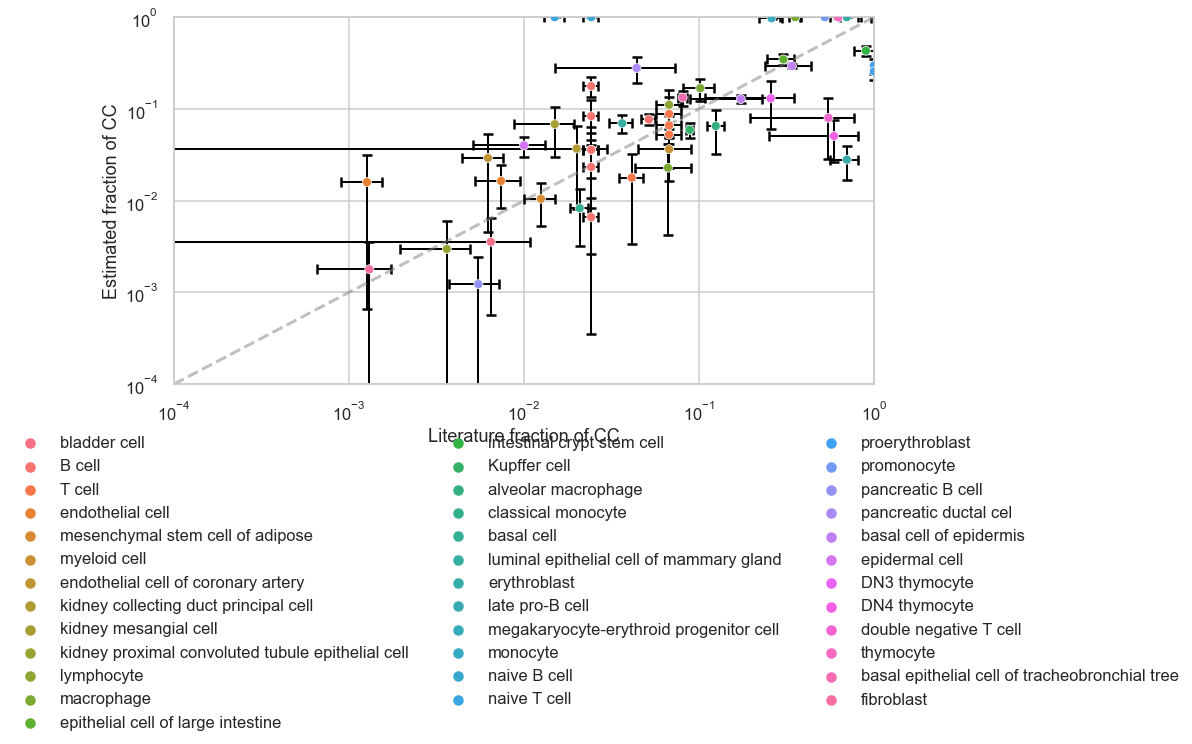

In [40]:
cc_an_for_comp = {}
for meth in tissues_by_method.keys():
    cc_an_for_comp[meth] = cc_an[meth].pivot_table(index=['tissue','cell_ontology_class'], values=['cc_frac','cc_std'], aggfunc='median')
    # cc_an_for_comp[meth] = cc_an[meth].pivot_table(index=['tissue','cell_ontology_class'], values=['cc_frac'], aggfunc=['median','std'])
    # cc_an_for_comp[meth].columns = ['cc_frac', 'cc_std']
    cc_an_for_comp[meth]['lit_cc_frac'] = lit['cc_compare']
    cc_an_for_comp[meth]['lit_cc_sd_low'] = lit['cc_sd_low']
    cc_an_for_comp[meth]['lit_cc_sd_hi'] = lit['cc_sd_hi']
    cc_an_for_comp[meth] = cc_an_for_comp[meth][(cc_an_for_comp[meth].cc_frac>0) & (~cc_an_for_comp[meth].lit_cc_frac.isnull())].copy()
    cc_an_for_comp[meth]['lit_x'] = jitter_log(cc_an_for_comp[meth].lit_cc_frac, s=0.05)


plt.figure(figsize=(15,11))
ax=plt.gca()
eb_all = ax.errorbar(cc_an_for_comp[meth].lit_cc_frac, cc_an_for_comp[meth].cc_frac, yerr=cc_an_for_comp[meth].cc_std, 
                     xerr=cc_an_for_comp[meth][['lit_cc_sd_low','lit_cc_sd_hi']].values.T, ls='', lw=2, color='k', marker='8', 
                        capsize=5, capthick=2.5,  zorder=2,)
sns.scatterplot(data=cc_an_for_comp[meth], x='lit_cc_frac', y='cc_frac', hue='cell_ontology_class', legend=True,ax=ax, zorder=3)
plt.plot([0.0001,1],[0.0001,1], 'grey', ls='--', alpha=0.5)
plt.xlim([0.0001,1])
plt.ylim([0.0001,1])
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Estimated fraction of CC')
plt.xlabel('Literature fraction of CC')
sns.move_legend(ax, "upper left", bbox_to_anchor=(-0.25, -0.1), ncol=3,title='')
plt.tight_layout()
plt.savefig('{}/lit_comp_indiv_level_{}_new_data.png'.format(present_dir,meth))

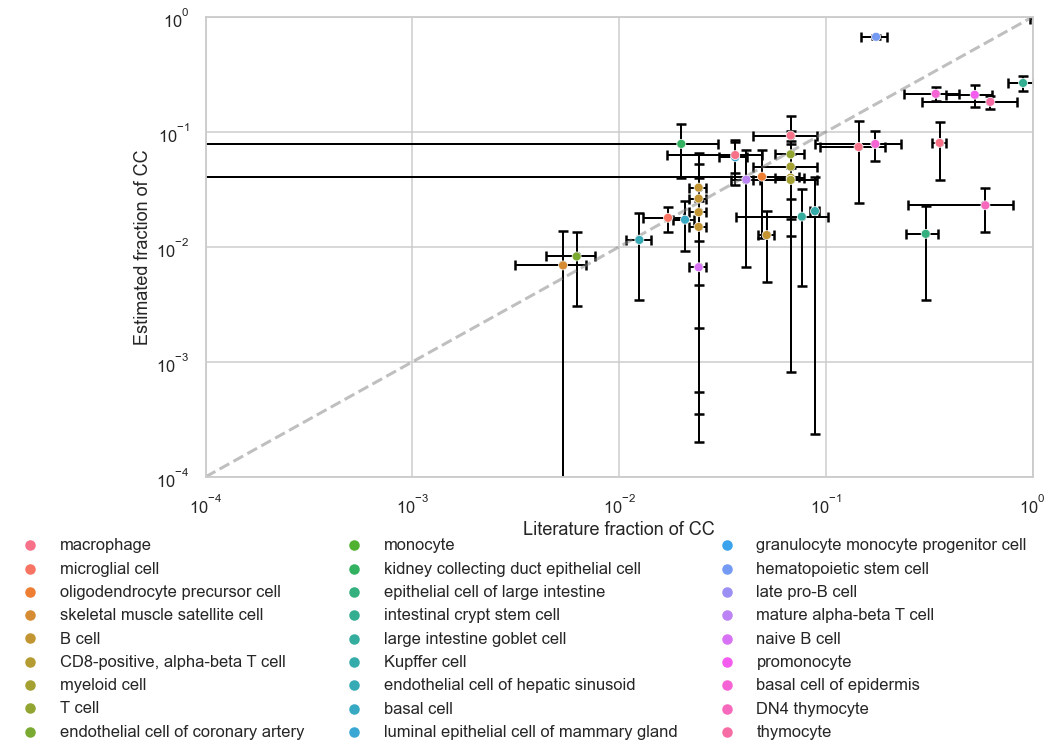

In [42]:
# cc_an_for_comp = {}
meth = 'facs'
    

plt.figure(figsize=(15,11))
ax=plt.gca()
eb_all = ax.errorbar(cc_an_for_comp[meth].lit_cc_frac, cc_an_for_comp[meth].cc_frac, yerr=cc_an_for_comp[meth].cc_std, 
                     xerr=cc_an_for_comp[meth][['lit_cc_sd_low','lit_cc_sd_hi']].values.T, ls='', lw=2, color='k', marker='8', 
                        capsize=5, capthick=2.5,  zorder=2,)
sns.scatterplot(data=cc_an_for_comp[meth], x='lit_cc_frac', y='cc_frac', hue='cell_ontology_class', legend=True,ax=ax, zorder=3)
plt.plot([0.0001,1],[0.0001,1], 'grey', ls='--', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.0001,1])
plt.ylim([0.0001,1])
plt.ylabel('Estimated fraction of CC')
plt.xlabel('Literature fraction of CC')
sns.move_legend(ax, "upper left", bbox_to_anchor=(-0.25, -0.1), ncol=3,title='')
plt.tight_layout()
plt.savefig('{}/lit_comp_indiv_level_{}_new_data.png'.format(present_dir,meth))

In [104]:
agg_ctypes_ind = bb[('cc_frac',0.5)] - bb[('cc_frac',0.1)]>0
bb.loc[agg_ctypes_ind,('cc_frac',0.5)] - bb.loc[agg_ctypes_ind, ('cc_frac',0.1)]
bb.loc[agg_ctypes_ind,('cc_frac',0.9)] - bb.loc[agg_ctypes_ind, ('cc_frac',0.5)]

new_ct
B cell              0.294813
T cell              0.273985
endothelial cell    0.001246
macrophage          0.277354
dtype: float64

In [43]:
meth= 'droplet'
aa = all_cc_comp[meth].reset_index()
aa['at_tissue'] = aa.tissue.str.contains('AT')
aa['new_tissue'] = aa.tissue.apply(lambda tiss: 'AT' if 'AT' in tiss else tiss)
aa['new_ct'] = aa.cell_ontology_class.apply(lambda ct: 'T cell' if 'T cell' in ct else ct)
aa['new_ct'] = aa.new_ct.apply(lambda ct: 'endothelial cell' if 'endothelial cell' in ct else ct)
aa['new_ct'] = aa.new_ct.apply(lambda ct: 'fibroblast' if 'fibroblast' in ct else ct)
aa['new_ct'] = aa.new_ct.apply(lambda ct: 'bladder cell' if 'bladder' in ct else ct)

aa = aa.groupby(['new_tissue','new_ct']).median()
bb = aa.groupby(['new_ct']).quantile([0.1, 0.5,0.9]).unstack()
agg_ctypes_ind = bb[('cc_frac',0.5)] - bb[('cc_frac',0.1)]>0
cc = aa.groupby(['new_ct']).median()
cc['cc_low'] = cc['cc_std']
cc['cc_hi'] = cc['cc_std']
cc.loc[agg_ctypes_ind,'cc_low'] = bb.loc[agg_ctypes_ind,('cc_frac',0.5)] - bb.loc[agg_ctypes_ind, ('cc_frac',0.1)]
cc.loc[agg_ctypes_ind,'cc_hi'] = bb.loc[agg_ctypes_ind,('cc_frac',0.5)] - bb.loc[agg_ctypes_ind, ('cc_frac',0.1)]
# bb[('cc_frac',0.75)] - bb[('cc_frac',0.5)]

In [44]:
cc

cc_pos  total_cells  \
new_ct                                                                   
B cell                                               19.0        310.0   
DN3 thymocyte                                        26.0        122.0   
DN4 thymocyte                                        63.0       1087.0   
Kupffer cell                                        234.0       2054.0   
Langerhans cell                                      11.0        141.0   
T cell                                               23.0        462.0   
alveolar macrophage                                  52.0        650.0   
basal cell                                           11.0       1089.0   
basal cell of epidermis                            1413.0       5655.0   
basal epithelial cell of tracheobronchial tree       52.0        397.0   
bladder cell                                          9.0       3741.5   
classical monocyte                                  338.0       3310.0   
endothelial cell                                     13.0        246.0   
epidermal cell                                       63.0       1710.0   
epithelial cell of large intestine                   73.0        220.0   
erythroblast                                       1087.5       1171.0   
erythroid progenitor                                356.0        366.0   
fibroblast                                            6.5       1298.5   
hepatic stellate cell                                 1.0         20.0   
hepatocyte                                            2.0       1816.0   
intestinal crypt stem cell                          107.0        275.0   
kidney collecting duct principal cell                25.0        629.0   
kidney mesangial cell                                19.0        205.0   
kidney proximal convoluted tubule epithelial cell    26.0       3086.0   
large intestine goblet cell                          19.0        145.0   
late pro-B cell                                     454.0        463.0   
luminal epithelial cell of mammary gland            105.0       1666.0   
lymphocyte                                          198.5        544.0   
macrophage                                          155.0        970.0   
megakaryocyte-erythroid progenitor cell            1283.5       1290.5   
mesenchymal stem cell of adipose                     32.0       1591.0   
monocyte                                           1972.0       2032.0   
myeloid cell                                         38.0       1562.0   
naive B cell                                        302.0        306.0   
pancreatic B cell                                     5.0       1439.0   
pancreatic ductal cel                                38.0        223.0   
podocyte                                             11.0        402.0   
proerythroblast                                     401.5       1194.5   
promonocyte                                        2771.0       2773.0   
skeletal muscle satellite cell                       10.0        926.0   
smooth muscle cell                                    3.0        288.0   
thymocyte                                          1738.0       1747.0   
type II pneumocyte                                    2.0        105.0   

                                                    cc_frac    cc_std  \
new_ct                                                                  
B cell                                             0.061290  0.009291   
DN3 thymocyte                                      0.213115  0.037075   
DN4 thymocyte                                      0.057958  0.007087   
Kupffer cell                                       0.113924  0.007010   
Langerhans cell                                    0.078014  0.022586   
T cell                                             0.066436  0.011153   
alveolar macrophage                                0.080000  0.010641   
basal cell                                         0.010101  0.

c:\Users\ronse\Anaconda3\lib\site-packages\numpy\core\_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\ronse\Anaconda3\lib\site-packages\numpy\core\_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


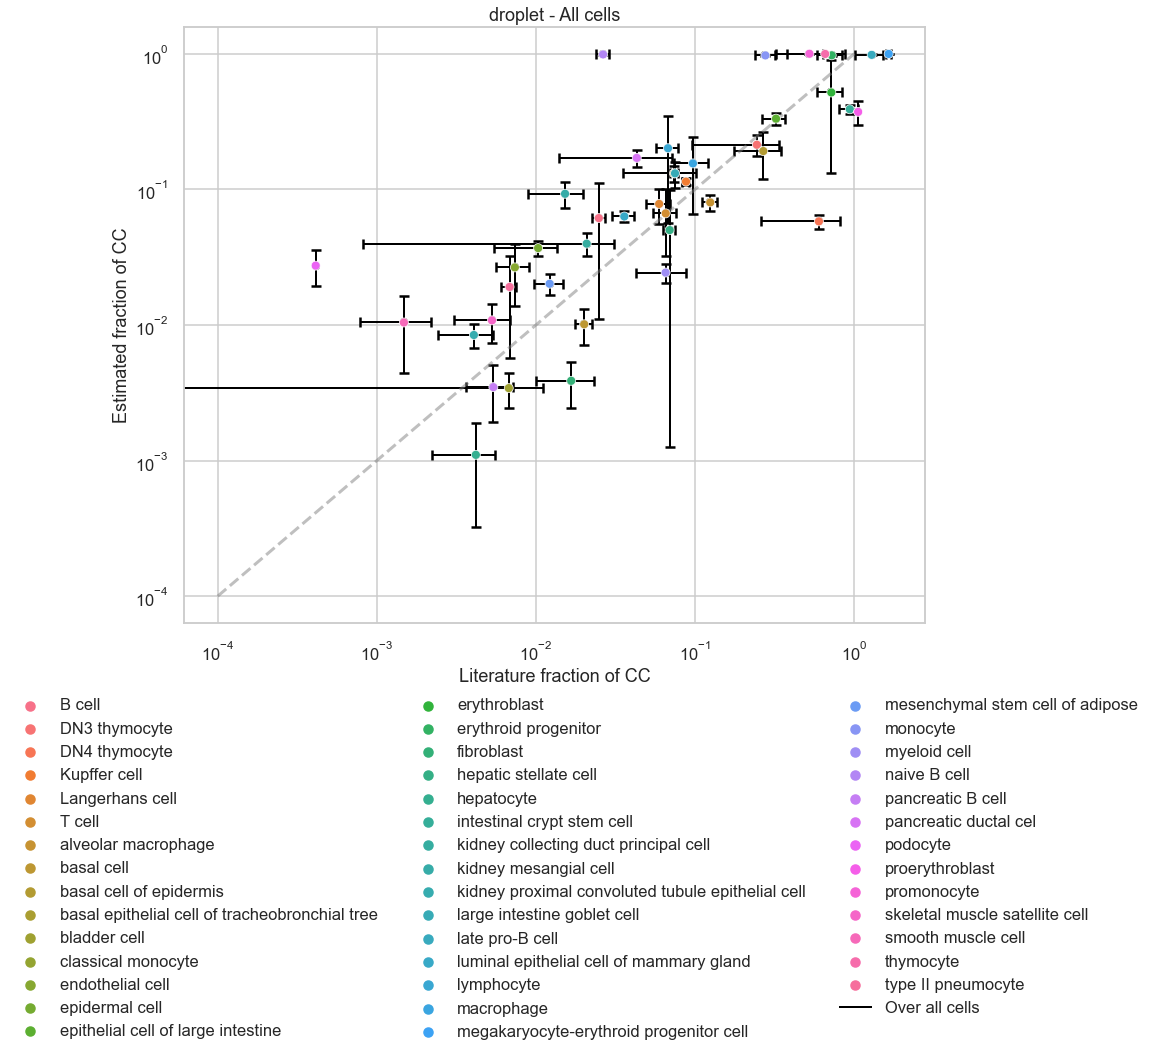

In [46]:

# meth = 'facs'
plt.figure(figsize=(15,15))

ax=plt.gca()
eb_all = ax.errorbar(cc.lit_x, cc.cc_frac, yerr=cc[['cc_low','cc_hi']].values.T, xerr=cc[['lit_cc_sd_low','lit_cc_sd_hi']].values.T,
             ls='', lw=2, color='k', marker='8',  capsize=5, capthick=2.5,  zorder=2, label='Over all cells')
sns.scatterplot(data=cc, x='lit_x', y='cc_frac', hue='new_ct', legend=True,ax=ax, zorder=3)
plt.plot([0.0001,1],[0.0001,1], 'grey', ls='--', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Estimated fraction of CC')
plt.xlabel('Literature fraction of CC')
sns.move_legend(ax, "upper left", bbox_to_anchor=(-0.25, -0.1), ncol=3,title='')
plt.tight_layout()
plt.title('{} - All cells'.format(meth))
plt.savefig('{}/lit_comp_grouped_cells_{}_new_data.png'.format(present_dir,meth))


In [47]:
meth= 'facs'
aa = all_cc_comp[meth].reset_index()
aa['at_tissue'] = aa.tissue.str.contains('AT')
aa['new_tissue'] = aa.tissue.apply(lambda tiss: 'AT' if 'AT' in tiss else tiss)
aa['new_ct'] = aa.cell_ontology_class.apply(lambda ct: 'T cell' if 'T cell' in ct else ct)
aa['new_ct'] = aa.new_ct.apply(lambda ct: 'endothelial cell' if 'endothelial cell' in ct else ct)
aa['new_ct'] = aa.new_ct.apply(lambda ct: 'fibroblast' if 'fibroblast' in ct else ct)
aa['new_ct'] = aa.new_ct.apply(lambda ct: 'bladder cell' if 'bladder' in ct else ct)

aa = aa.groupby(['new_tissue','new_ct']).median()
bb = aa.groupby(['new_ct']).quantile([0.1, 0.5,0.9]).unstack()
agg_ctypes_ind = bb[('cc_frac',0.5)] - bb[('cc_frac',0.1)]>0
cc = aa.groupby(['new_ct']).median()
cc['cc_low'] = cc['cc_std']
cc['cc_hi'] = cc['cc_std']
cc.loc[agg_ctypes_ind,'cc_low'] = bb.loc[agg_ctypes_ind,('cc_frac',0.5)] - bb.loc[agg_ctypes_ind, ('cc_frac',0.1)]
cc.loc[agg_ctypes_ind,'cc_hi'] = bb.loc[agg_ctypes_ind,('cc_frac',0.5)] - bb.loc[agg_ctypes_ind, ('cc_frac',0.1)]
# bb[('cc_frac',0.75)] - bb[('cc_frac',0.5)]

c:\Users\ronse\Anaconda3\lib\site-packages\numpy\core\_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\ronse\Anaconda3\lib\site-packages\numpy\core\_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


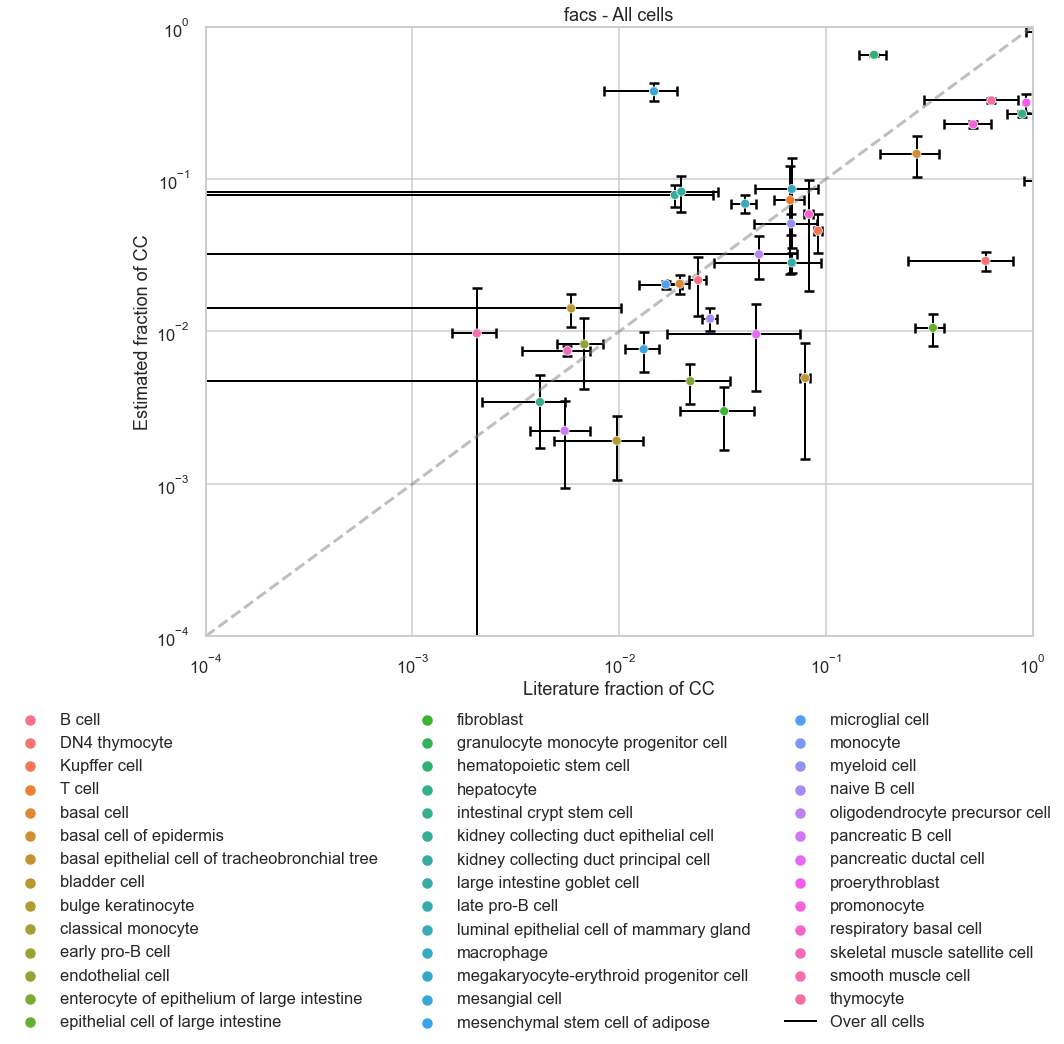

In [49]:

# meth = 'facs'
plt.figure(figsize=(15,15))

ax=plt.gca()
eb_all = ax.errorbar(cc.lit_x, cc.cc_frac, yerr=cc[['cc_low','cc_hi']].values.T, xerr=cc[['lit_cc_sd_low','lit_cc_sd_hi']].values.T,
             ls='', lw=2, color='k', marker='8',  capsize=5, capthick=2.5,  zorder=2, label='Over all cells')
sns.scatterplot(data=cc, x='lit_x', y='cc_frac', hue='new_ct', legend=True,ax=ax, zorder=3)
plt.plot([0.0001,1],[0.0001,1], 'grey', ls='--', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.0001,1])
plt.ylim([0.0001,1])
plt.ylabel('Estimated fraction of CC')
plt.xlabel('Literature fraction of CC')
sns.move_legend(ax, "upper left", bbox_to_anchor=(-0.25, -0.1), ncol=3,title='')
plt.tight_layout()
plt.title('{} - All cells'.format(meth))
plt.savefig('{}/lit_comp_grouped_cells_{}_new_data.png'.format(present_dir,meth))
